<a href="https://colab.research.google.com/github/jlifferth/UQ-BIO-2022/blob/main/Module_2_2_Supervised_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning with Python

----------
## Qbio Summer School 2022

--------------
```
Instructor: Will Raymond
Author: Will Raymond
Contact Info: wsraymon@rams.colostate.edu
```
<details>
  <summary>Copyright info</summary>

```
Copyright 2022 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>


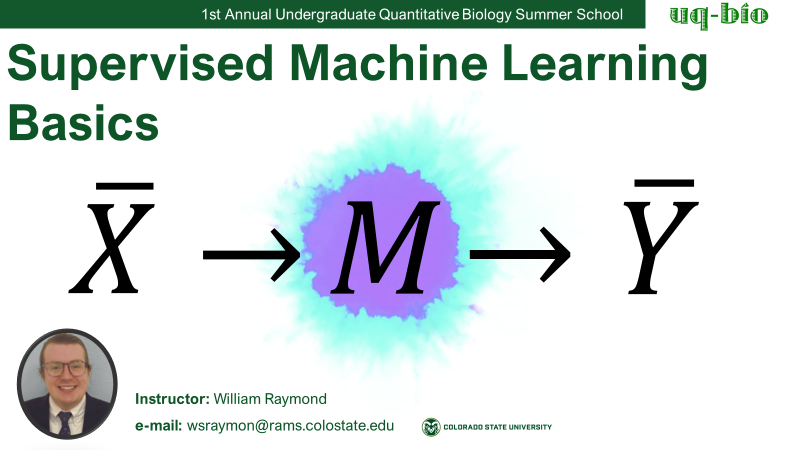

In this notebook and lecture we are going to look at some supervised machine learning basics. Lets start of with a definition:
 
Machine learning (ML) is a class of mathematics and algorithms that learn an arbitrary model, $M$, from sample data, $\bar{X}$, to fit a target $\bar{Y}$ usually by minimizing a given loss function, $L$. Sample data can be provided with or without explanatory labels. The model learned is not explicitly programmed hence the name "Machine Learning." Broadly, ML falls under the umbrella of Artificial Intelligence, although that field has other disciplines besides ML. 
 
Python is one of the most popular platforms for machine learning and the three main libraries used for machine learning are:
 
* [Tensorflow](https://www.tensorflow.org/)
* [PyTorch](https://pytorch.org/)
* [Sci-kit Learn](https://scikit-learn.org/stable/)
 
Tensorflow and Pytorch are the main packages for creating custom neural networks while Sci-kit learn focuses on providing common ML classifiers such as SVM, K-means, Decision trees and many, many more. Pytorch and Tensorflow (as of 2022) account for roughly 50% and 25% of new machine learning repositories in GitHub. Much digital ink has been spilled extolling the pros and cons of each framework, however my personal best advice is to use whichever package has previous models for your particular problem uncovered by a literature search.
 
![tf_vs_pytorch](https://raw.githubusercontent.com/MunskyGroup/uqbio2021/main/module_2/figures/pytorch_vs_tensorflow.png)
 
 
For the purposes of this notebook we will be using tensorflow which integrates nicely with Google Colab. 
 



In [ ]:
#@title imports
%%capture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  

# getting the matplotlib style template from our qbio repo
plt.rcParams['figure.dpi'] = 120
!git clone https://github.com/MunskyGroup/uqbio2021
plt.style.use('/content/uqbio2021/templates/mplstyle/uqbio_light.mplstyle')

#importing tensorflow and sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score

# importing different classifers from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# importing some other stuff
from scipy.ndimage.filters import gaussian_filter # gaussian filter
import PIL #image handling
from PIL import  Image
from tqdm.notebook import tqdm #notebook progress bar

import os #file handling
import glob #linux file handling parsing
import pickle

print("TensorFlow version:", tf.__version__)
!nvidia-smi -L #check if we are connected to a GPU

## Data Generation


-------------------

Toy problem:

You are a microscopist wishing to train a machine learning model to classify if a cell is currently in the field of view of your microscope. You create a dataset of images of cells and blank backgrounds and label them for your supervised machine learning.

---------------------
We have two options:

Generate some fake data to train on, or use the real microscope images. 

Below are two blocks that gather real data off of our github that I have hand labeled for y'all. The images in this set are of size 32 x 32 x 3.

The second one generates some random cell shapes and microscope background images of the shape: N images x 128 x 128 x 3 as well as mask images of the shape N images x 128 x 128 x 1.

(if you want to check out the type of algorithm used to generate the cells it's a brute force implementation of [metaballs](https://en.wikipedia.org/wiki/Metaballs), please note there are faster ways to generate these shapes than brute force!)

\begin{align}
\bar{X} = Images = Tensor(N_{images}, Height, Width, Color) = (1000,128,128,1)
\end{align}

### Real Images

In [ ]:
%%capture

print('Getting subimages.....')
# get a tar.gz from the uqbio_2022 github containing 1000 32x32 subsampled images w/ labels
!wget -nc https://raw.githubusercontent.com/MunskyGroup/uqbio2022/master/files/files_ml/subimages_128_sorted.tar.gz
!mkdir /content/subimage_dataset
!tar -xzvf /content/subimages_128_sorted.tar.gz -C /content/

print('Getting images.....')
# pulling the original 1296 images from our ftp page
!wget -q --recursive -np bitbio.org/images_128/ -P /content/ --accept py, JPG, jpg --reject index*
!mv bitbio.org/images_128 .
!rm -r bitbio.org/


In [ ]:
## Read these files into numpy arrays

blanks = glob.glob('/content/subimages_128_sorted/blank/*.png')
cells = glob.glob('/content/subimages_128_sorted/cells_in_fov/*.png')


imgs = []
labels = []
for cell_image in cells: #for images containing cells
  image = Image.open(cell_image) #use PIL to open the image
  imageAsNumpyArray = np.array(image).astype(np.uint8) #convert to uint8
  imgs.append(imageAsNumpyArray)
  labels.append(1)

for blank_image in blanks: #for images containing blanks
  image = Image.open(blank_image)  #use PIL to open the image
  imageAsNumpyArray = np.array(image).astype(np.uint8) #convert to uint8
  imgs.append(imageAsNumpyArray)
  labels.append(0)

real_data = np.array(imgs)  #store these as two np arrays, data and labels
real_data_labels = np.array(labels) #convert the list of labels into a numpy array


imgs = []
fullFilePaths = glob.glob('images_128/*.jpg') #find all files ending in .jpg
for fullFilePath in fullFilePaths:  #for each of those files, convert to numpy array
    filePathSplitIntoList=fullFilePath.split('_')
    ImageFileStringAndExtenstion=filePathSplitIntoList[2].split('.')
    imageIdAsInteger=int(ImageFileStringAndExtenstion[0])
    image = Image.open(fullFilePath)
    imageAsNumpyArray = np.array(image).astype('int32')
    imgs.append(imageAsNumpyArray)

X_128 = np.array(imgs)

In [ ]:
print(real_data.shape)
print(real_data_labels.shape)

(1000, 32, 32, 3)
(1000,)


### Fake Images

In [ ]:
N_images = 500 #@param {type:"slider", min:0, max:1000, step:1}

# metaball algorithm parameters,
# be warned changing these will drastically change the shape of 
# the fake cells

goo = 1.72
threshold = .08

#image size nxn
size = 128

fake_cells = np.zeros([N_images, size, size, 3], dtype=np.uint8)
fake_cells_masks = np.zeros([N_images, size, size, 1], dtype=np.uint8)

fake_blanks= np.zeros([N_images, size, size, 3], dtype=np.uint8)
fake_blanks_masks = np.zeros([N_images, size, size, 1], dtype=np.uint8)

def make_metaball_bruteforce(positions, size_balls, goo, r):
    nballs = len(size_balls)
    mask = np.zeros([size,size])
    for i in range(size):
        for j in range(size):
            ballsum = 0
            for k in range(nballs):
                ballsum += size_balls[k] / ( np.sqrt( (positions[k][0] - i )**2 + (positions[k][1] - j )**2)**goo)
            
                if ballsum > r:
                    mask[i,j] = 1
                    break
            if ballsum > r:
                mask[i,j] = 1
    return mask
    
def make_random_cell():
  ## random cell shape
    pos = []
    size = []
    size_factor = [6,3,3,2,2]
    for n in range(np.random.randint(3,6)):
        pos.append((64+ np.random.randn()*15, 64+np.random.randn()*15))
        s = -1
        while s <= 0:
            s = np.random.randn()*size_factor[n] + 10
        size.append(s)
    return pos, size

def make_random_blank():
  ## random blank slide with small junk
    pos = []
    size = []
    size_factor = [1,1,.5,1,1,2,1,.5,1,1,.5,.5,1]
    for n in range(np.random.randint(7,13)):
        pos.append((64+ np.random.randn()*64, 64+np.random.randn()*64))
        s = -1
        while s <= 0:
            s = np.random.randn()*size_factor[n] + 3
        
        size.append(s)
        
    return pos, size   

def make_cell_image():
    
    cell_mask = make_metaball_bruteforce(*make_random_cell(), goo, threshold)
    cell_mask_int = cell_mask.astype(np.uint8)
    cell_mask = gaussian_filter(cell_mask,sigma=3)
    img = np.random.randint(20,128,size = [128,128,3]) 
    
    
    a = (np.random.randn(128,128)*30 + 32)
    a[a < 0] = 30
    r = np.multiply(a,cell_mask)
    
    a = (np.random.randn(128,128)*30 + 220)
    a[a < 0] = 200    
    g = np.multiply(a,cell_mask)

    a = (np.random.randn(128,128)*10 + 32)
    a[a < 0] = 30        
    b = np.multiply(a,cell_mask)
    
    img  = img + np.concatenate([r[:,:,np.newaxis], g[:,:,np.newaxis], b[:,:,np.newaxis]], axis=-1)
    img[img > 255] = 255
    
    return img.astype(np.uint8), cell_mask_int

def make_blank_image():
    
    cell_mask = make_metaball_bruteforce(*make_random_blank(), goo, threshold+.01)
    cell_mask_int = cell_mask.astype(np.uint8)
    cell_mask = gaussian_filter(cell_mask,sigma=3)
    img = np.random.randint(20,128,size = [128,128,3]) 
    
    
    a = (np.random.randn(128,128)*50 + 64)
    a[a < 0] = 64
    r = np.multiply(a,cell_mask)
    
    a = (np.random.randn(128,128)*30 + 220)
    a[a < 0] = 200    
    g = np.multiply(a,cell_mask)

    a = (np.random.randn(128,128)*10 + 64)
    a[a < 0] = 15        
    b = np.multiply(a,cell_mask)
    
    img  = img + np.concatenate([r[:,:,np.newaxis], g[:,:,np.newaxis], b[:,:,np.newaxis]], axis=-1)
    img[img > 255] = 255
    
    return img.astype(np.uint8), cell_mask_int


print('Generating Fake cells.....')
for i in tqdm(range(N_images)):
    img, mask = make_cell_image()
    fake_cells[i,:,:,:] = img
    fake_cells_masks[i,:,:,:] = mask[:,:,np.newaxis]*255


print('Generating blank backgrounds w/ junk.....')
for i in tqdm(range(N_images)):
    img, mask = make_blank_image()
    fake_blanks[i,:,:,:] = img
    fake_blanks_masks[i,:,:,:] = mask[:,:,np.newaxis]*255

print('Final cell data size: ')
print(fake_cells.shape)

print('Final blank data size: ')
print(fake_blanks.shape)

In [ ]:
## Select Real or Fake dataset
#@title select real or fake dataset to use

use_real_dataset = True #@param {type:"boolean"}

if not use_real_dataset:
  X = np.concatenate([fake_cells,fake_blanks],axis=0)
  Y = np.zeros([2*N_images])
  Y[:N_images] = 1

  Y_onehot = tf.one_hot(Y,2)
  print(X.shape)
  print(Y_onehot.shape)

else:
  X = np.copy(real_data)
  Y = np.copy(real_data_labels)
  Y_onehot = tf.one_hot(Y,2)



## Data Selection and Preperation

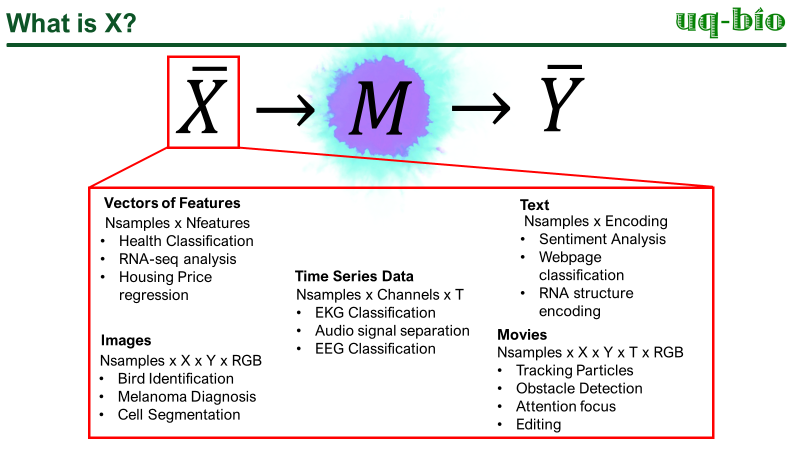

### What is X?

$\bar{X}$, your input data, can take many shapes, forms and sizes. One of the most common is an unordered vector of some arbitrary features. For example one could imagine a classifier algorithm that takes inputs about a patient's health and returns a probability that they may have diabetes. That input data may be formatted as such:

\begin{equation}
  \bar{X} = [ \text{Int : Age}, \text{Int : Urinations per day},  \text{Float : Liters drank per day}, \text{Bool : Peripheral Numbness}]
\end{equation}

And an example entry may be 
\begin{equation}
  \bar{X}_0 = [ 27, 6, 1.5, Y ]
\end{equation}


 
### Ordered vs unordered data
 
If the above data has a corresponding label saying whether the entries in your data truly have diabetes this dataset is said to be labeled, and you can use **Supervised** machine learning techniques. When your dataset has an absence of labels, then any approaches are said to be **Unsupervised.**
 
 
--------------------------
 
Ordered datasets can come in many shapes ranging from something like Text (1xN vector where sequence is important) to full color movies (X by Y by Color channel by number of frames). All of these can be represented by an arbitrary tensor of the correct shape by number of entries in your dataset.
 
\begin{equation}
  Shape(\bar{X}) = Nsamples \times Dim_1 \times Dim_2 ... Dim_N
\end{equation}
 
 


Here we have a dataset of images of a microscope's field of view. We want to train a classifier that detects when a cell is in frame and returns to us the boolean "Is there a cell in the frame of view?"
 
Let's take a look at a positive and negative example from our dataset:


Text(0.5, 1.0, 'Negative Example (label = 0)')

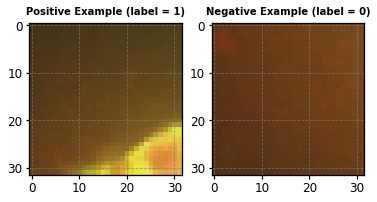

In [ ]:
n_samples = X.shape[0]                        #how many data points do we have?
positives = int(np.sum(Y == 1))               #how many labeled positive?
negatives = int(np.sum(Y == 0))               #how many labeled negative

positive_example = X[Y==1][np.random.randint(positives)] #get a random positive example
negative_example = X[Y==0][np.random.randint(negatives)] #get a random negative example

# plot those examples
fig,ax = plt.subplots(1,2)
ax[0].imshow(positive_example)
ax[0].set_title('Positive Example (label = 1)',fontsize=10)
ax[1].imshow(negative_example)
ax[1].set_title('Negative Example (label = 0)',fontsize=10)

Feature Extraction

What are some features we can extract from these images?

In [ ]:
#@title Select normalization type
norm = "channel_max" #@param ["channel_max","indiv_max","none"]

if norm =="channel_max":
  X_norm = X/ np.array([np.max(X[:,:,:,0]),np.max(X[:,:,:,1]),np.max(X[:,:,:,2])])
elif norm == "none":
  X_norm = X/1
elif norm == "indiv_max":
  X_norm = np.zeros(X.shape)
  X_norm[:,:,:,0] = X[:,:,:,0] /np.max(X[:,:,:,0],axis=(1,2))[:,np.newaxis,np.newaxis]
  X_norm[:,:,:,1] = X[:,:,:,1] /np.max(X[:,:,:,1],axis=(1,2))[:,np.newaxis,np.newaxis]
  X_norm[:,:,:,2] = X[:,:,:,2] /np.max(X[:,:,:,2],axis=(1,2))[:,np.newaxis,np.newaxis]
else:
  X_norm = X/1        


In [ ]:
def get_features_from_image(image):
  img = np.copy(image) #copy our image so we dont change the original array

  # how about the average intensity in the green channel?
  Average_intensity_g = np.mean(img[:,:,1])
  # how about the average intensity in the red channel?
  Average_intensity_r = np.mean(img[:,:,0])
  # how about the average intensity in the blue channel?
  Average_intensity_b = np.mean(img[:,:,2])

  def rgb_cov(im): #get the covariance of intensity in each channel
      im = np.copy(im)
      im_re = im.reshape(-1, 3)
      im_re -= np.mean(im_re,axis=1)[:,np.newaxis]
      return (1/(im_re.shape[0]-1) * im_re.T @ im_re).flatten()

  # lets calculate a mask percentage for each channel using a threshold,
  # basically how much area in the image is above 50% of the maximum value?
  cov_I = rgb_cov(img)
  thresh = .5 #threshold for image masking
  r_mask = np.sum(img[:,:,0] > thresh)/(img.shape[0]**2)
  g_mask = np.sum(img[:,:,1] > thresh)/(img.shape[0]**2)
  b_mask = np.sum(img[:,:,2] > thresh)/(img.shape[0]**2)

  # concatentate and return our features

  #variance of edge detection
  average_r_diff = np.var(img[1:,1:,0] - img[:-1,:-1,0])
  average_g_diff = np.var(img[1:,1:,1] - img[:-1,:-1,1])
  average_b_diff = np.var(img[1:,1:,2] - img[:-1,:-1,2])
  return [Average_intensity_r,Average_intensity_g,Average_intensity_b] + cov_I.flatten().tolist() + [r_mask, g_mask, b_mask] +  [average_r_diff, average_g_diff, average_b_diff]

X_features_all = np.zeros([X.shape[0], 18]) #preallocate and array all of our features
for i in range(X.shape[0]):
  X_features_all[i,:] = get_features_from_image(X_norm[i]) #fill in that array for each image




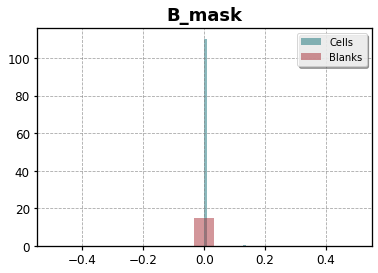

In [ ]:
#@title plot some of our extracted features
feature = "B_mask" #@param ["R_mean", "G_mean", "B_mean", "I_cov_1", "I_cov_2", "I_cov_3", "I_cov_4", "I_cov_5", "I_cov_6", "I_cov_7", "I_cov_8", "I_cov_9", "R_mask", "G_mask", "B_mask"]
feature_index = ["R_mean", "G_mean", "B_mean", "I_cov_1", "I_cov_2", "I_cov_3", "I_cov_4", "I_cov_5", "I_cov_6", "I_cov_7", "I_cov_8", "I_cov_9", "R_mask", "G_mask", "B_mask"].index(feature)

plt.hist(X_features_all[Y==1,feature_index], bins=15, alpha=.5, density=True)
plt.hist(X_features_all[Y==0,feature_index], bins=15, alpha=.5, density=True)
plt.title(feature)
plt.legend(['Cells','Blanks'])


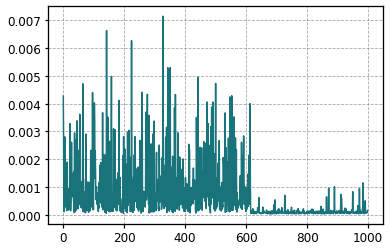

In [ ]:
plt.plot(X_features_all[:,-3])

In [ ]:
#@title select the features to use for later learning
R_mean = True #@param {type:"boolean"}
G_mean = True #@param {type:"boolean"}
B_mean = False #@param {type:"boolean"}
I_cov = False #@param {type:"boolean"}

mask_percent_R = True #@param {type:"boolean"}
mask_percent_G = True #@param {type:"boolean"}
mask_percent_B = False #@param {type:"boolean"}

edge_detect_variance_r = True #@param {type:"boolean"}
edge_detect_variance_g = True #@param {type:"boolean"}
edge_detect_variance_b = False #@param {type:"boolean"}

features = []
feat_names = []
if R_mean:
  features.append(X_features_all[:,0][:,np.newaxis])
  feat_names.append('R_mean')
if G_mean:
  features.append(X_features_all[:,1][:,np.newaxis])
  feat_names.append('G_mean')
if B_mean:
  features.append(X_features_all[:,2][:,np.newaxis])
  feat_names.append('B_mean')
if I_cov:
  features.append(X_features_all[:,2:2+9])
  for i in range(9):
    feat_names.append('I_cov_%i'%i)
if mask_percent_R:
  features.append(X_features_all[:,-6][:,np.newaxis])
  feat_names.append('Mask_per_R')

if mask_percent_G:
  features.append(X_features_all[:,-5][:,np.newaxis])
  feat_names.append('Mask_per_G')

if mask_percent_B:
  features.append(X_features_all[:,-4][:,np.newaxis])
  feat_names.append('Mask_per_B')


if edge_detect_variance_r:
  features.append(X_features_all[:,-3][:,np.newaxis])
  feat_names.append('Edgevar_R')

if edge_detect_variance_g:
  features.append(X_features_all[:,-2][:,np.newaxis])
  feat_names.append('Edgevar_G')

if edge_detect_variance_b:
  features.append(X_features_all[:,-1][:,np.newaxis])
  feat_names.append('Edgevar_B')

X_features = np.hstack(features)



## Target Selection

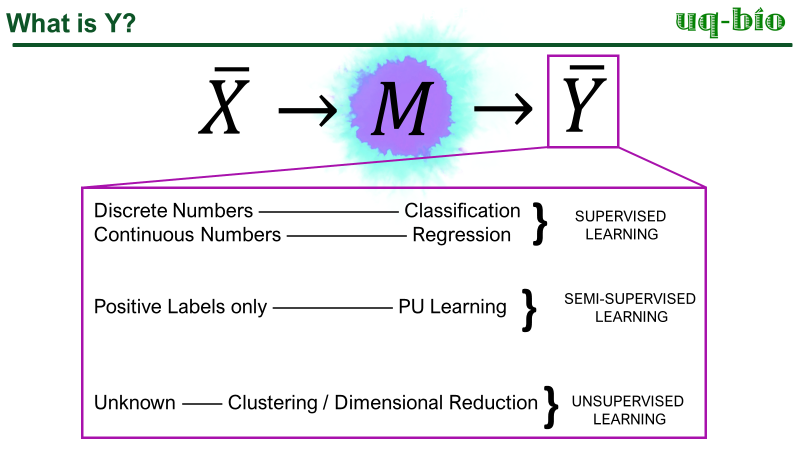

---------------
### Classification 
---------------
------------
$\bar{Y}$ is our target for our ML model to learn. If our input data label $Y$ is a set of boolean labels, then we are setting up a model to solve a classification problem. For example training a classifier to tell if a picture contains a cat or a dog, our data set would look like $\bar{X}$ of shape $[N, X,Y, RGB]$ and $Y$ our labels would be shape $[N]$ with labels 0 for a cat or 1 for a dog (or vice versa). Comparing true labels $Y$ with predicted labels $\bar{Y}$ is our model's loss function:

\begin{equation}
  \bar{L} = F(Y, \bar{Y}) 
\end{equation}

An appropriate selection for this classification problem would be binary cross entropy:

\begin{equation}
  -\frac{1}{N} \sum_{i=1}^N Y_i*log(p(Y_i)) + (1-Y_i)*log(1-p(Y_i))
\end{equation}

which is a fancy way of summing up the probability for each sample in the probability that the entry is labeled 1 or 0. We will talk more about this later.

A simpler but less refined way could also be minimizing the error between true and predicted labels by calculating $\sum_{i=1}^N abs(Y_i - \bar{Y}_i)$.








------------------
###Regression 
---------------


When the desired output is a continuous value instead of a label, then we are training a model to perform a regression. An example problem would be taking a dataset of house features, $\bar{X}$, and their current market prices $Y$ and training a model to produce predicted prices for other houses $\bar{Y}$.

An appropriate loss function for this situation may be the mean squared error (MSE) for your predicted prices and the true prices:

\begin{equation}
MSE = \frac{1}{N}\sum_{i=1}^N abs(Y_i - \bar{Y}_i)^2
\end{equation}

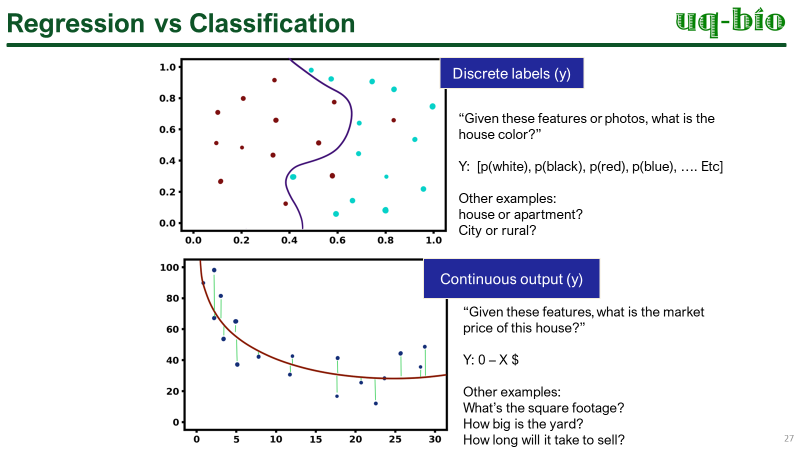

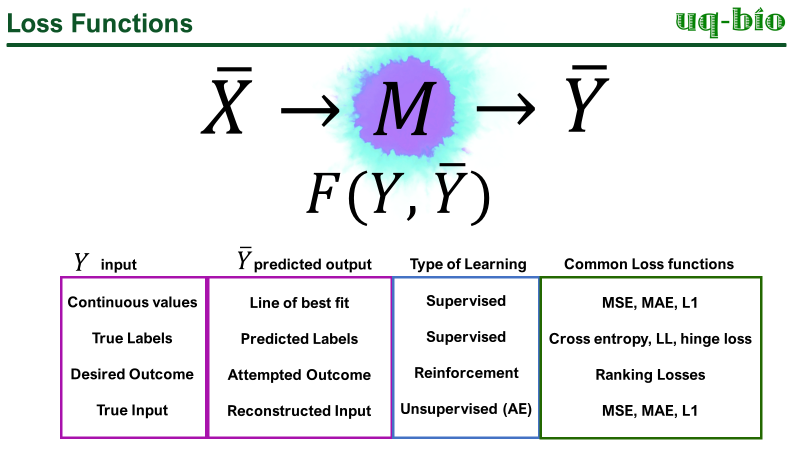

## Model Types and Selection

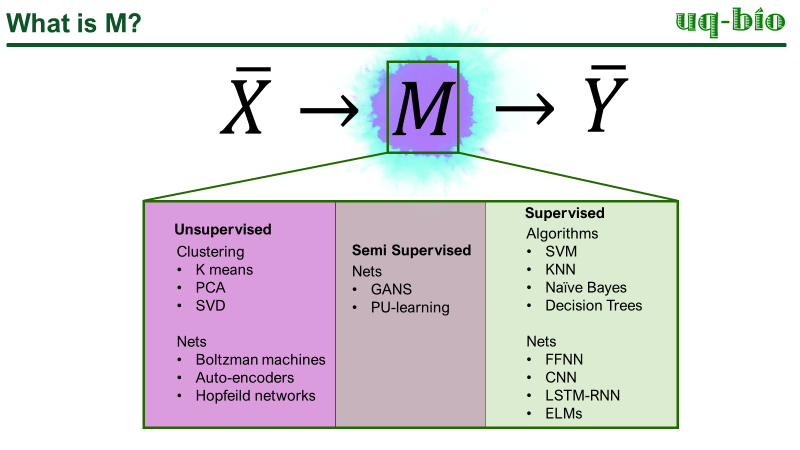

$M$ in our definition is any arbitrary model. Above are a couple common models and algorithms used for fitting data. 


------------------
###Regression 
---------------


When the desired output is a continuous value instead of a label, then we are training a model to perform a regression. An example problem would be taking a dataset of house features, $\bar{X}$, and their current market prices $Y$ and training a model to produce predicted prices for other houses $\bar{Y}$.

An appropriate loss function for this situation may be the mean squared error (MSE) for your predicted prices and the true prices:

\begin{equation}
MSE = \frac{1}{N}\sum_{i=1}^N abs(Y_i - \bar{Y}_i)^2
\end{equation}

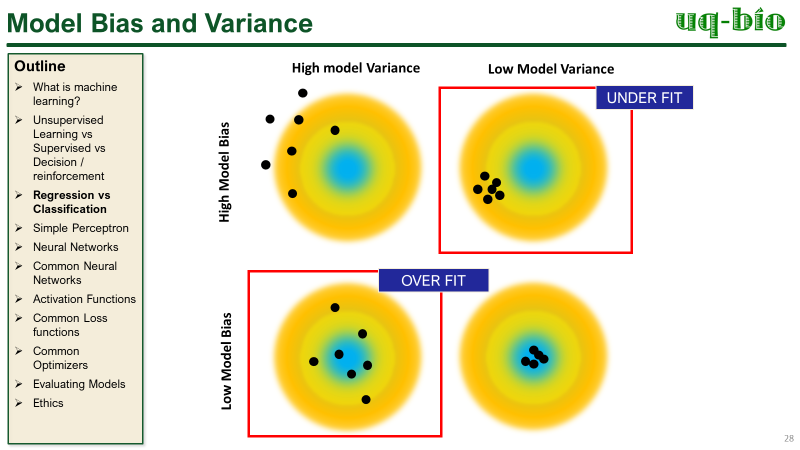

Ideally we want a model to be generalizable to new data, Which of the three below would be considered a good fit?

A good model acts as a map to its real world process, a good map doesn't show you every stone and blade of grass along the path, but instead the overarching **generalized** idea. 

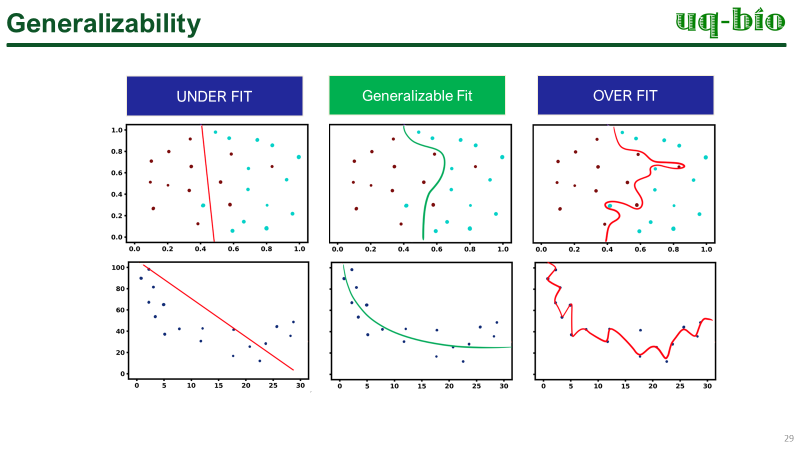

### Ordinary Least Squares Regression


Given $X$ feature matrix what's the MOST simple model we can devise that uses all the features?

Ordinary Least Squares Regression!

Each feature is assigned its own weight $w_i$ and the predicted output for each data point / vector is:

\begin{align}
x_{i,j}*w_j + x_{i,j+1}*w_{j+1} .... + x_{i,n}*w_{n} = y_{i}
\end{align}

giving us the equation:

\begin{align}
 W\cdot\bar{X} = \bar{Y} 
\end{align}

for the matrices: 

\begin{align}
\mathbf{\bar{Y}} = \begin{bmatrix}
y_1&\\
y_2&\\
\vdots&\\
y_n&\\
\end{bmatrix}	
\mathbf{W} = \begin{bmatrix}
w_1&\\
w_2&\\
\vdots&\\
w_n&\\
\end{bmatrix}	
\mathbf{\bar{X}} = \begin{bmatrix}
x_{1,1}& x_{1,2} &\cdots& x_{1,i}\\
x_{2,1}& \ddots & &\vdots&\\ 
\vdots& & \ddots&\\
x_{n,1}& \cdots& & x_{n,i}\\
\end{bmatrix}	
\end{align}



There's a nice linear algebra solution for directly solving for the weights that minimize the Ordinary Least Squares (L2 Norm).

\begin{equation}
W = (\bar{X}^T\cdot \bar{X})^{-1}\bar{X}^T \cdot \bar{Y} = pseudoinverse(\bar{X})*\bar{Y}
\end{equation}

To bring it back to the slides above, our $M$, model in this case is $\bar{X} \cdot W$.


In [ ]:
print('shape of X: %s'%str(X_features.shape)) # whats the shape of X
W = np.linalg.pinv(X_features)@Y[:,np.newaxis] #getting our Weights
print('shape of W: %s'%str(W.shape)) # whats the shape of W

Yhat = X_features@W # prediction of Y

## Applying a threshold
Yp_class = Yhat >.5
accuracy_score(Y,Yp_class)

shape of X: (1000, 6)
shape of W: (6, 1)


0.728

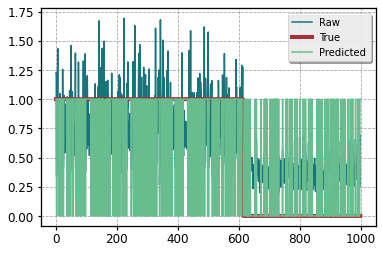

In [ ]:
plt.plot(Yhat); plt.plot(Y,lw=4); plt.plot(Yp_class,'-',ms=2);  plt.legend(['Raw','True','Predicted'])

[Text(0, 0, 'R_mean'),
 Text(0, 0, 'G_mean'),
 Text(0, 0, 'Mask_per_R'),
 Text(0, 0, 'Mask_per_G'),
 Text(0, 0, 'Edgevar_R'),
 Text(0, 0, 'Edgevar_G')]

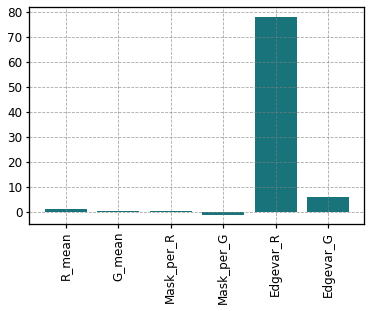

In [ ]:
# plot our learned linear weights
fig,ax = plt.subplots(1)
ax.bar(np.arange(X_features.shape[1]),W.flatten())
ax.set_xticks(np.arange(X_features.shape[1]))
ax.set_xticklabels(feat_names,rotation=90) 

### Least Squares Regression w/ Regularization Matrix
 
How do we enforce our Weights to be as small as possible? Large weights can cause lots of model variance on unseen data and over fit our linear regression model.
 
\begin{equation}
W = (\bar{X}^T\cdot \bar{X} + \lambda^2 I)^{-1}\bar{X}^T \cdot \bar{Y} 
\end{equation}
 
where $\lambda I$  is the identity matrix of size features times a power constant for how strong the regularization should be.
 
In this case we are using "L2 regularization" which is to say there is a penalty on the SQUARED value of the weights. There is an easy linear algebra derivation that lets you solve for this case directly. The other case common in machine learning is "L1 regularization" which is a penalty on the ABSOLUTE value of weights chosen, however this has no easy linear algebra solution so we aren't covering it right now.
 

In [ ]:
lam = 2 #@param {type:"slider", min:0, max:3, step:0.1}

W2 = np.linalg.inv((X_features.T @ X_features + 
                    lam**2*np.eye(X_features.shape[1]))) @ X_features.T @ Y

Yhat2 = X_features@W2
Yp_class2 = Yhat2>.5
print(accuracy_score(Y, Yp_class2))
print(W2)

0.707
[ 1.28738007  0.21637447  0.6472622  -0.70259909  0.0228499   0.01388757]


#### Faster linear algebra version

In [ ]:
n_new_weights = X_features.shape[1]
n_data_points = X_features.shape[0]
X_feat2 = np.zeros([n_data_points + n_new_weights, X_features.shape[1] ])

X_feat2[:n_data_points,:] = X_features #copy in the data points

lam = 2 #@param {type:"slider", min:0, max:3, step:0.1}

X_feat2[n_data_points:,:] = np.eye(n_new_weights)*lam #add the identity matrix 

Y2 =np.zeros([n_data_points + n_new_weights,1]) #add new blank targets
Y2[:n_data_points] = Y[:,np.newaxis]

W2 = np.linalg.pinv(X_feat2)@Y2
Yhat2 = X_features@W2
Yp_class2 = Yhat2>.5
print(accuracy_score(Y, Yp_class2))
print(W2)

0.708
[[ 1.23236958]
 [ 0.29005622]
 [ 0.58164097]
 [-0.43891239]
 [ 0.01031552]
 [ 0.00518628]]


[Text(0, 0, 'R_mean'),
 Text(0, 0, 'G_mean'),
 Text(0, 0, 'Mask_per_R'),
 Text(0, 0, 'Mask_per_G'),
 Text(0, 0, 'Edgevar_R'),
 Text(0, 0, 'Edgevar_G')]

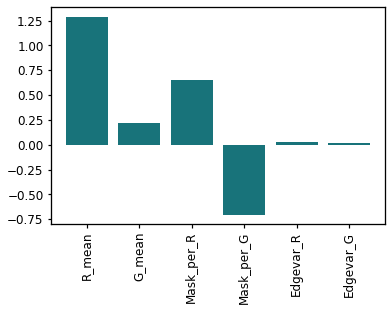

In [ ]:
fig,ax = plt.subplots(1)
ax.bar(np.arange(X_features.shape[1]),W2.flatten())
ax.set_xticks(np.arange(X_features.shape[1]))
ax.set_xticklabels(feat_names,rotation=90) 

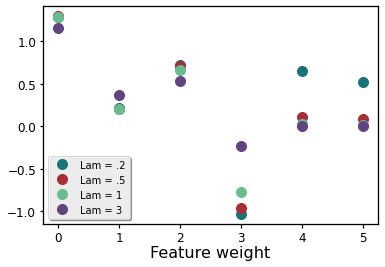

In [ ]:
for lam in [.2,.5,1,3]:
  X_feat2[n_data_points:,:] = np.eye(n_new_weights)*lam #add the identity matrix 
  W2 = np.linalg.pinv(X_feat2)@Y2
  plt.plot(W2,'o'); plt.legend(['Lam = .2', 'Lam = .5', 'Lam = 1', 'Lam = 3' ])
  plt.xlabel('Feature weight')

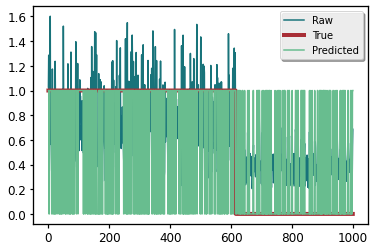

In [ ]:
plt.plot(Yhat2); plt.plot(Y,lw=4); plt.plot(Yp_class2,'-',ms=2);  plt.legend(['Raw','True','Predicted'])

### Least Squares Regression w/ L2 and Bias Term

We can also add in the bias term, the ```b``` in ```y = m*x+b``` for our linear regression model. We can simply add in an column of 1's to our data matrix, a column not dependent on X.

\begin{align}
x_{i,j}*w_j + x_{i,j+1}*w_{j+1} .... + x_{i,n}*w_{n} + 1 * w_{n+1} = y_{i}
\end{align}

giving us the equation:

\begin{align}
 W\cdot\bar{X} = \bar{Y} 
\end{align}

for the matrices: 

\begin{align}
\mathbf{\bar{Y}} = \begin{bmatrix}
y_1&\\
y_2&\\
\vdots&\\
y_n&\\
\end{bmatrix}	
\mathbf{W} = \begin{bmatrix}
w_1&\\
w_2&\\
\vdots&\\
w_n&\\
\end{bmatrix}	
\mathbf{\bar{X}} = \begin{bmatrix}
x_{1,1}& x_{1,2} &\cdots& x_{1,i} & 1\\
x_{2,1}& \ddots & &\vdots& \vdots &\\ 
\vdots& & \ddots& \vdots& \vdots\\
x_{n,1}& \cdots& & x_{n,i} & 1\\
\end{bmatrix}	
\end{align}

And the same solution for minimizing the Mean Squared Error:

\begin{equation}
W = (\bar{X}^T\cdot \bar{X} + \lambda^2 I)^{-1}\bar{X}^T \cdot \bar{Y} 
\end{equation}
 

In [ ]:
n_weights = X_features.shape[1]
n_data_points = X_features.shape[0]

X_feat_w_bias = np.ones([n_data_points, n_weights + 1 ]) #adding a column of 1's 
X_feat_w_bias[:n_data_points,:n_weights] = X_features #copy in the data points

lam = 0.5 #@param {type:"slider", min:0, max:3, step:0.1}


W_w_bias = np.linalg.pinv((X_feat_w_bias.T @ X_feat_w_bias + lam**2*np.eye(n_weights+1))) @ X_feat_w_bias.T @ Y

Yhat2 = X_feat_w_bias@W_w_bias
Yp_class2 = Yhat2>.5
print(accuracy_score(Y, Yp_class2))

0.8


[Text(0, 0, 'R_mean'),
 Text(0, 0, 'G_mean'),
 Text(0, 0, 'Mask_per_R'),
 Text(0, 0, 'Mask_per_G'),
 Text(0, 0, 'Edgevar_R'),
 Text(0, 0, 'Edgevar_G'),
 Text(0, 0, 'bias term')]

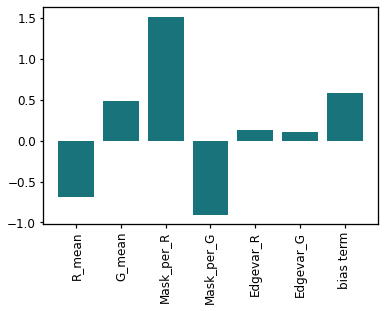

In [ ]:
fig,ax = plt.subplots(1)
ax.bar(np.arange(X_features.shape[1] + 1),W_w_bias.flatten())
ax.set_xticks(np.arange(X_features.shape[1] + 1))
ax.set_xticklabels(feat_names + ['bias term'],rotation=90) 

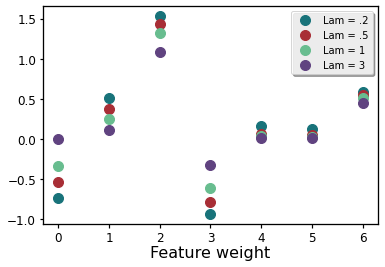

In [ ]:
for lam in [.2,.5,1,3]:
  W_w_bias = np.linalg.pinv((X_feat_w_bias.T @ X_feat_w_bias + lam*np.eye(n_weights+1))) @ X_feat_w_bias.T @ Y
  plt.plot(W_w_bias,'o'); plt.legend(['Lam = .2', 'Lam = .5', 'Lam = 1', 'Lam = 3' ])
  plt.xlabel('Feature weight')

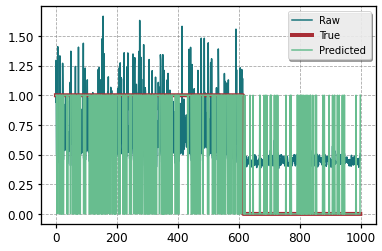

In [ ]:
plt.plot(Yhat2); plt.plot(Y,lw=4); plt.plot(Yp_class2,'-',ms=2);  plt.legend(['Raw','True','Predicted'])

### Nonlinear Classifiers, other M's
 
Nonlinear classifiers have a Non-linear decision boundary and learning process. 
 
The linear regression we have been using so far merely draws a hyperplane in the dimension of space of (N features - 1) of our $\bar{X}$ feature matrix, points on either side of the hyperplane are classified as 0 or 1.
 
A nonlinear classifier can draw a decision boundary as a surface in the same dimension, thus leading to higher accuracy and higher risk of over-fitting.
 
 

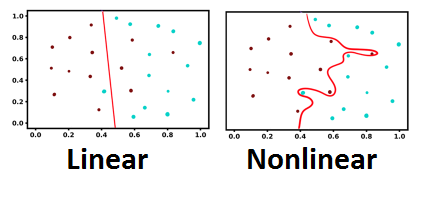

In [ ]:

classifier_type = "Naive Bayes" #@param ["Random Forest", "SVC", "KNN","Naive Bayes"]

classifier = {"Random Forest": RandomForestClassifier(max_depth=3),
              "SVC": SVC(gamma="auto"),
              "KNN": KNeighborsClassifier(n_neighbors=3),
              "Naive Bayes": GaussianNB()}

clf = classifier[classifier_type]

x_train, x_val, label_train, label_val = train_test_split(X_features, Y, test_size=.2,random_state=42)
clf.fit(x_train, label_train)
acc = accuracy_score(label_val, clf.predict(x_val))
print('Using the classifier %s: achieved %f percent accuracy on witheld data.'%(classifier_type,acc*100 ))


Using the classifier Naive Bayes: achieved 80.000000 percent accuracy on witheld data.


Text(0, 0.5, 'Validation Accuracy')

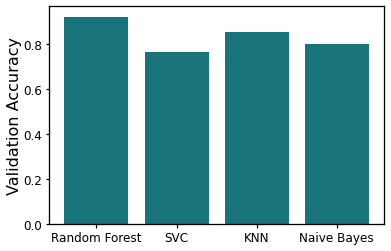

In [ ]:
accuracies = []
for classifier_type in classifier.keys():  #for each classifier in that dictionary, apply our classifier
  clf = classifier[classifier_type]
  x_train, x_val, label_train, label_val = train_test_split(X_features, Y, test_size=.2,random_state=42)
  clf.fit(x_train, label_train)
  acc = accuracy_score(label_val, clf.predict(x_val)) #store the accuracy for us to plot
  accuracies.append(acc)

plt.bar([0,1,2,3],accuracies,tick_label= ["Random Forest", "SVC", "KNN","Naive Bayes"])
plt.ylabel('Validation Accuracy')

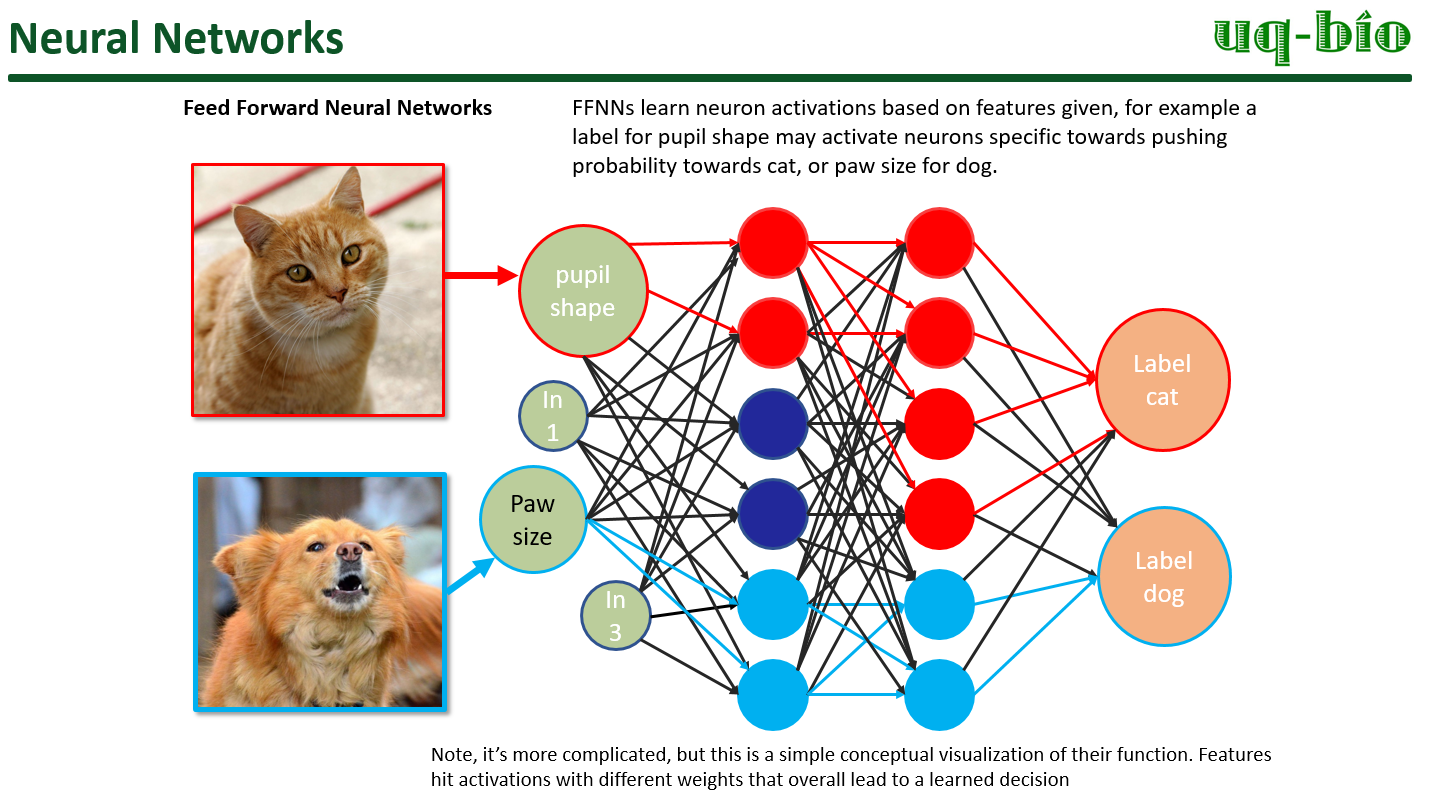

Below is a bit of code that lets us design a Feed Forward Neural net in tensorflow.

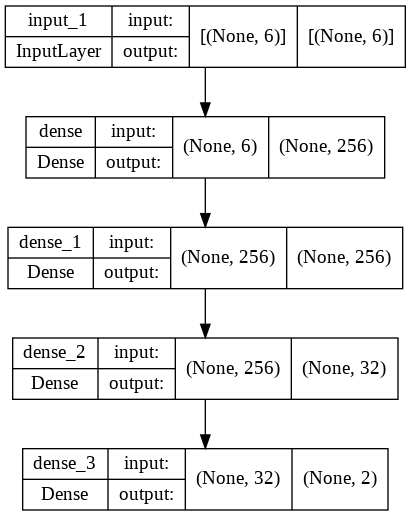

In [ ]:
#@title FFNN Designer
input_size = X_features.shape[1] 
total_classes = 2
total_dense_layers = 3 #@param slider {type:"slider", min:0, max:8, step:1}
activation_function = 'relu' #@param ["relu", "tanh", "sigmoid","linear"]
loss_function = 'categorical_crossentropy' #@param ["categorical_crossentropy", "categorical_hinge", "MAE","MSE"]
dropout = False
dense_neurons = "256,256,32" #@param {type:"string"}
dropout_percent = 0.12#@param slider {type:"slider", min:0, max:1, step:0.01}
input_list = lambda strinput: [int(x) for x in strinput.split(',')]

ffnn_model = keras.Sequential(); ffnn_model.add(keras.layers.InputLayer(input_size)) # input layer
## Dense layers layers
for i in range(total_dense_layers):
  ffnn_model.add(keras.layers.Dense(input_list(dense_neurons)[i], activation = activation_function, kernel_regularizer='l2'))
  if dropout:
    ffnn_model.add(keras.layers.Dropout(dropout_percent))
#final classification layer
if total_classes > 2:
  final_activation = 'softmax'
else:
  final_activation = 'softmax'
ffnn_model.add(keras.layers.Dense(total_classes, activation = final_activation))
ffnn_model.compile(loss=loss_function,
              optimizer='adam',
              metrics=['accuracy'])
keras.utils.plot_model(ffnn_model, "tmp.png", show_shapes=True)


##### Softmax vs sigmoid output
 
Sigmoid outputs are used to convert activations to independent values from 0 to 1, e.g. if a final layer of a neural network is size 4, sigmoid will normalize the final output to a vector of size 4 ranging from 0 to 1. This is analogous to independent probabilities of multiple classes.
 
\begin{equation}
sigmoid(x) = \frac{1}{1 + e^{-x}}
\end{equation}
 
 
 
Softmax outputs are used to convert activations to **DEPENDENT** values from 0 to 1, e.g. if a final layer of a neural network is size 4, sigmoid will normalize the final output to a vector of size 4 ranging from 0 to 1, but the sum of this vector will equal 1. This is analogous to joint probabilities of multiple classes.
 
\begin{equation}
sotfmax(x_j) = \frac{e^{x_j}}{\sum_{k=1}^N e^{x_k}} \text{for j} = 1,...,N
\end{equation}
 
 


## Training, Testing, and Validation

A key concept in training machine learning models is to validate your model on witheld data. You can either validate with a single test set or perform something called cross validation, where you break your full dataset into k subsets of training and testing data. A 5 fold cross validation would split your data into 5 sets of 80:20 split:

[A, B, C, D, E] would be split into training test sets as follows:
```
       train test
set 1: [ABCD] [E]
set 2: [ABCE] [D]
set 3: [ABDE] [C]
set 4: [ACDE] [B]
set 5: [BCDE] [A]
```

sklearn has a nice function called test_train_split that can randomize and split your data into testing and training called ```test_train_split```

### Training on one 80:20 split

In [ ]:
x_train, x_val, label_train, label_val = train_test_split(X_features, Y, test_size=.2,random_state=42)

label_train_onehot = tf.one_hot(label_train,2)
label_val_onehot = tf.one_hot(label_val,2)

ffnn_model.fit(x = x_train, y=label_train_onehot, validation_data = (x_val,label_val_onehot) ,epochs=30 )

Epoch 1/30
25/25 [==============================] - 2s 40ms/step - loss: 3.0449 - accuracy: 0.6175 - val_loss: 2.2553 - val_accuracy: 0.6050
Epoch 2/30
25/25 [==============================] - 0s 11ms/step - loss: 1.7628 - accuracy: 0.6488 - val_loss: 1.3461 - val_accuracy: 0.6100
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 1.0977 - accuracy: 0.7225 - val_loss: 0.8885 - val_accuracy: 0.8000
Epoch 4/30
25/25 [==============================] - 0s 12ms/step - loss: 0.7843 - accuracy: 0.7925 - val_loss: 0.6821 - val_accuracy: 0.8050
Epoch 5/30
25/25 [==============================] - 0s 10ms/step - loss: 0.6447 - accuracy: 0.8025 - val_loss: 0.5919 - val_accuracy: 0.8200
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5809 - accuracy: 0.8062 - val_loss: 0.5475 - val_accuracy: 0.8150
Epoch 7/30
25/25 [==============================] - 0s 10ms/step - loss: 0.5517 - accuracy: 0.8050 - val_loss: 0.5267 - val_accuracy: 0.8200
Epoch 8/30
25/2

Text(0, 0.5, 'Validation Accuracy')

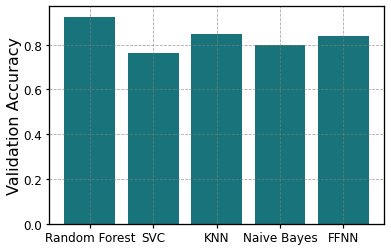

In [ ]:
acc = accuracy_score(label_val, ffnn_model.predict(x_val)[:,-1] > .5  )

ffnn_pred = ffnn_model.predict(x_val)[:,-1]
plt.bar([0,1,2,3,4],accuracies + [acc,],tick_label= ["Random Forest", "SVC", "KNN","Naive Bayes","FFNN"])
plt.ylabel('Validation Accuracy')

## Cross Validation

Below is an example of cross validation using sklearns built in kfold module, to read more check out: https://scikit-learn.org/stable/modules/cross_validation.html.

### Training on a 5-fold cross validation

Training....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


[0.82  0.83  0.835 0.77  0.775]


Text(0.5, 0, 'Classifier')

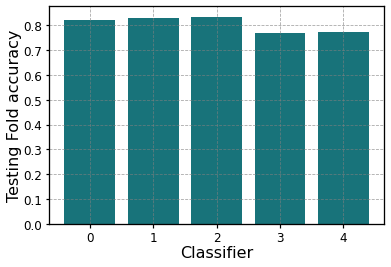

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from keras.wrappers.scikit_learn import KerasClassifier

# to get a neural network to work with sklearn we have to wrap it in a function then a 
# Keras classifier class

def make_ffnn():

  input_size = X_features.shape[1] 
  total_classes = 2
  total_dense_layers = 3 #@param slider {type:"slider", min:0, max:8, step:1}
  activation_function = 'relu' #@param ["relu", "tanh", "sigmoid","linear"]
  loss_function = 'categorical_crossentropy' #@param ["categorical_crossentropy", "categorical_hinge", "MAE","MSE"]
  dropout = False
  dense_neurons = "256,64,32" #@param {type:"string"}
  dropout_percent = 0.12#@param slider {type:"slider", min:0, max:1, step:0.01}
  input_list = lambda strinput: [int(x) for x in strinput.split(',')]

  ffnn_model = keras.Sequential(); ffnn_model.add(keras.layers.InputLayer(input_size)) # input layer
  ## Dense layers layers
  for i in range(total_dense_layers):
    ffnn_model.add(keras.layers.Dense(input_list(dense_neurons)[i], activation = activation_function, kernel_regularizer='l2'))
    if dropout:
      ffnn_model.add(keras.layers.Dropout(dropout_percent))
  #final classification layer
  if total_classes > 2:
    final_activation = 'softmax'
  else:
    final_activation = 'softmax'
  ffnn_model.add(keras.layers.Dense(total_classes, activation = final_activation))
  ffnn_model.compile(loss=loss_function,
                optimizer='adam',
                metrics=['accuracy'])
  return ffnn_model

## making the wrapper with the build NN function
print('Training....')
nn = KerasClassifier(build_fn=make_ffnn, 
                                 epochs=20, 
                                 batch_size=100, 
                                 verbose=0)
X_feat_shuffled,Y_shuffled = sklearn.utils.shuffle(X_features,Y)
scores = cross_val_score(nn, X_feat_shuffled,Y_shuffled, cv=5, scoring="accuracy")
print(scores)

plt.figure()
plt.bar(np.arange(5), scores)
plt.ylabel('Testing Fold accuracy')
plt.xlabel('Classifier')


In [ ]:
print('Predicting....')
Y_predicted_shuffled = cross_val_predict(nn, X_feat_shuffled,Y_shuffled, cv=5)

Predicting....


In [ ]:
accuracy_score(Y_shuffled, Y_predicted_shuffled)

0.816

## Training a CNN
Below is a bit of code that lets us design a 2D Convolutional Neural network in tensorflow

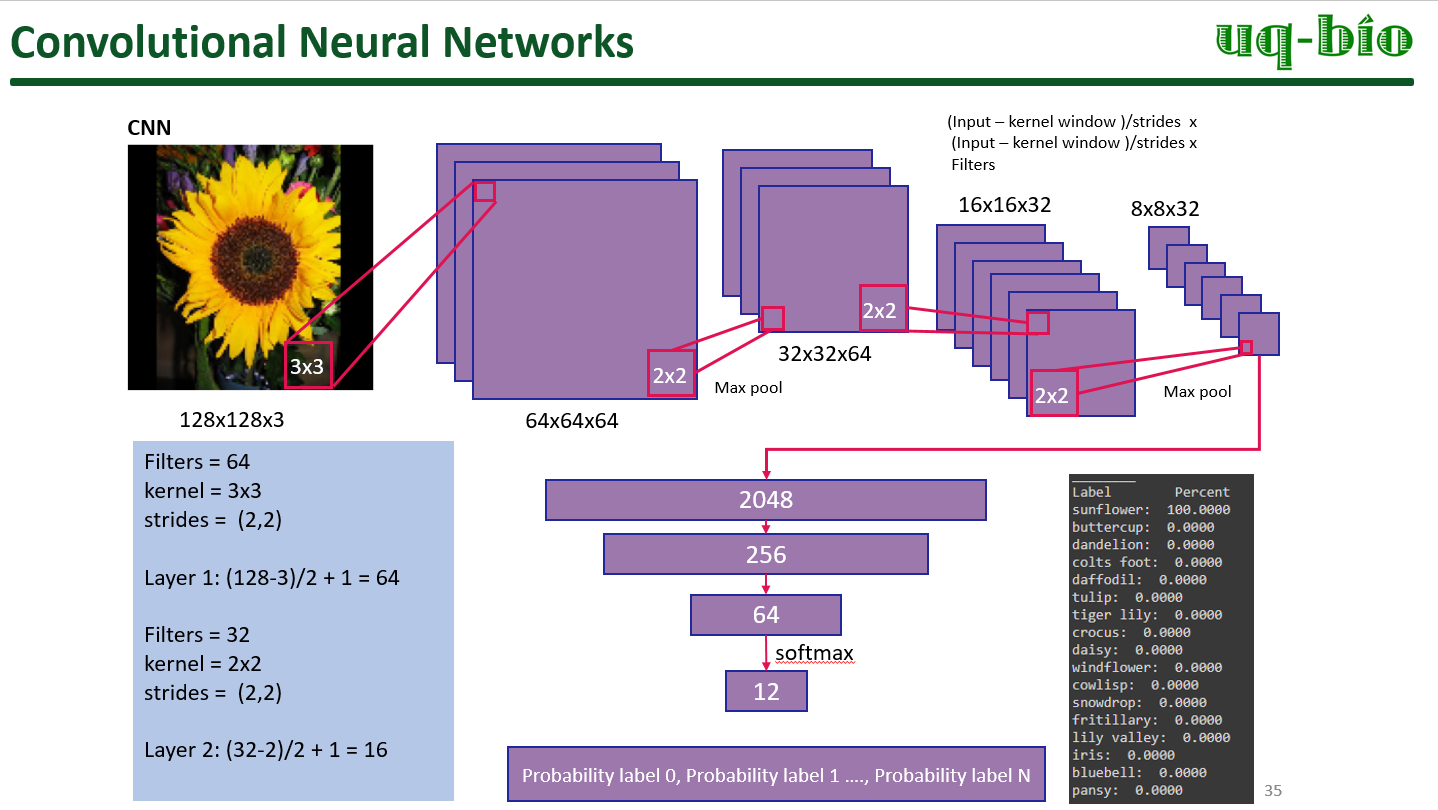

#### Before we do a full CNN, lets do one Convolution on our own just to see how it works.

Below is an example of an edge detection kernel, the kernel is what our convolutional neural network will learn!

Text(0.5, 1.0, 'Negative Example (label = 0)')

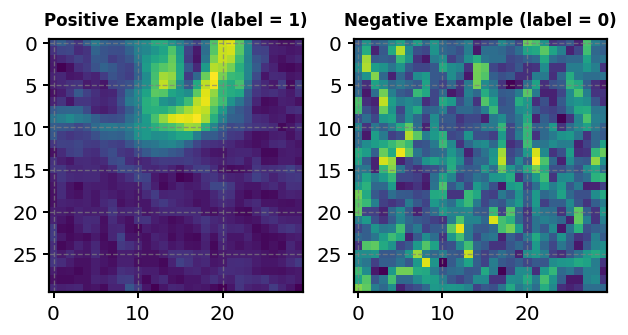

In [ ]:
## Define our convolution kernel here

## This is a simple Sobel kernel, this approximates the derivative
#  over a vertical or horizontal direction

v_edge_kernel = np.array([[1,0,-1],
                          [2,0,-2],
                          [1,0,-1]],dtype=int)

h_edge_kernel = v_edge_kernel.T  #horiztonal kernel


def conv_2d_numpy(image, kernel, bias=0):
  '''
  a function that performs a 2d convolution in numpy

  Parameters
  ----------
  image : ndarray
      ndarray of size X,Y.
  kernel : ndarray
      kernel to convolve with.
  bias : float, optional
      bias term to the convolution, added to the final pixel. The default is 0.

  Returns
  -------
  ndarray
      image X,Y numpy array of the convolved kernel and original image.

  '''
  m,n = kernel.shape                        #size of our kernel
  image_shape = image.shape                 # image shape

  # pad our original image by 2 pixels on all sides, so we start from 0,0 to n+2,n+2
  padx = m-1
  pady = n-1
  padded_image = np.zeros([image.shape[0]+2*padx, image.shape[1] + pady*2],dtype=image.dtype)
  padded_image[padx:-padx,pady:-pady] = image

  # preallocate a new image to fill
  convolved_image = np.zeros([image.shape[0]+padx*2, image.shape[1]+pady*2])

  #sweep across all pixels with the kernel
  for i in range(image.shape[0]+padx*2-4): 
    for j in range(image.shape[1]+pady*2-4):
      convolved_image[i][j] = np.sum(padded_image[i:i+m, j:j+n]*kernel) + bias #get the new pixel
  return convolved_image[padx:-padx-2,pady:-pady-2] #return the unpadded image

# Pick a new positive and negative example
n_samples = X.shape[0]
positives = int(np.sum(Y == 1))
negatives = int(np.sum(Y == 0))
positive_example = X[Y==1][np.random.randint(positives)]
negative_example = X[Y==0][np.random.randint(negatives)]

## Apply our two convolutions here and recombine the images for both positive and negative example images
positive_edges = np.sqrt(conv_2d_numpy(positive_example[:,:,1], v_edge_kernel,0)**2 + conv_2d_numpy(positive_example[:,:,1],h_edge_kernel,0)**2 )
negative_edges = np.sqrt(conv_2d_numpy(negative_example[:,:,1],v_edge_kernel,0)**2 + conv_2d_numpy(negative_example[:,:,1],h_edge_kernel,0)**2)

fig,ax = plt.subplots(1,2,dpi=120)
ax[0].imshow(positive_edges.astype(float))
ax[0].set_title('Positive Example (label = 1)',fontsize=10)
ax[1].imshow(negative_edges.astype(float))
ax[1].set_title('Negative Example (label = 0)',fontsize=10)

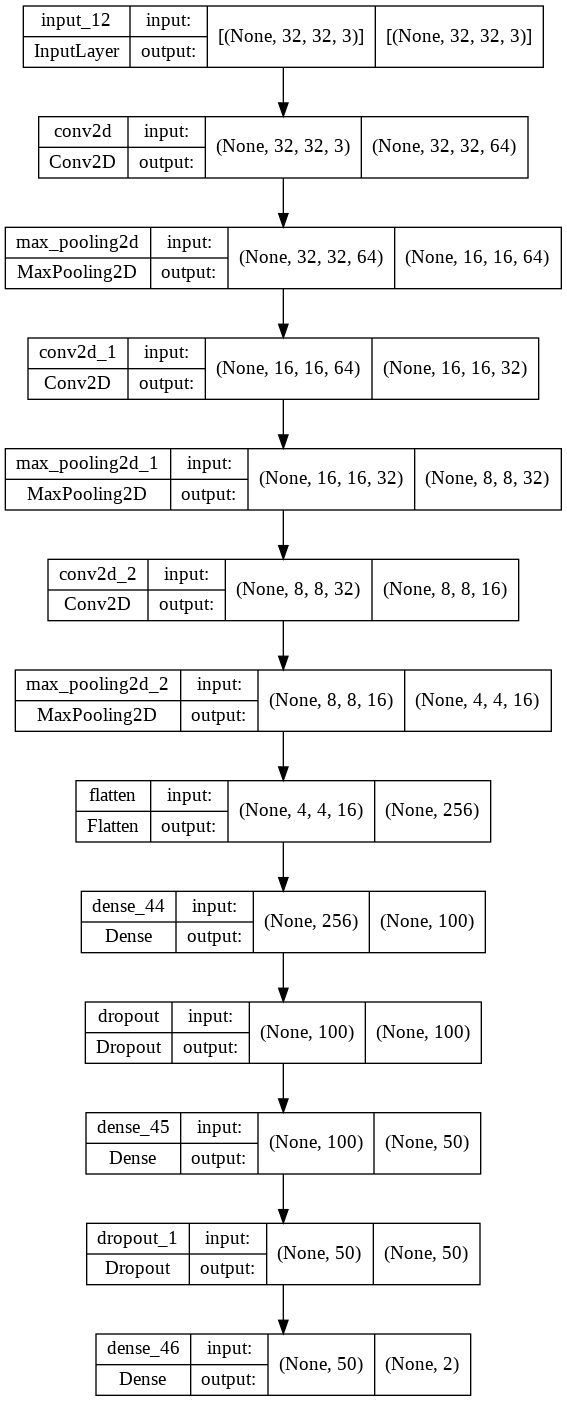

In [ ]:
#@title 2D CNN Designer

w = X.shape[1]
h = X.shape[2]

total_classes = 2
total_cnn_layers = 3 #@param slider {type:"slider", min:0, max:8, step:1}
total_dense_layers = 2 #@param slider {type:"slider", min:0, max:8, step:1}
maxpooling = True 
dropout = True #@param {type:"boolean"}
activation_function = 'relu' #@param ["relu", "tanh", "sigmoid","linear"]
loss_function = 'categorical_crossentropy' #@param ["categorical_crossentropy", "categorical_hinge", "MAE"]
dropout_percent=.1
filter_sizes = "64,32,16" #@param {type:"string"}
kernel_sizes = "4,3,2" #@param {type:"string"}
strides = "1,1,1" #@param {type:"string"}
pool_sizes = "2,2,2" #@param {type:"string"}
input_list = lambda strinput: [int(x) for x in strinput.split(',')]


dense_neurons = "100,50" #@param {type:"string"}


model = keras.Sequential(); model.add(keras.Input(shape=(w, h, 3))) # input layer


## CNN layers
for i in range(total_cnn_layers):
  pool_size = input_list(pool_sizes)[i]
  stride_size =  input_list(strides)[i]
  model.add(keras.layers.Conv2D(input_list(filter_sizes)[i], input_list(kernel_sizes)[i], (stride_size, stride_size), activation=activation_function,padding='same', kernel_regularizer='l2'))
  if maxpooling:
    model.add(keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)))


model.add(keras.layers.Flatten())

## Dense layers layers
for i in range(total_dense_layers):
  model.add(keras.layers.Dense(input_list(dense_neurons)[i], activation = activation_function, kernel_regularizer='l2'))
  if dropout:
    model.add(keras.layers.Dropout(dropout_percent))

if total_classes > 2:
  final_activation = 'softmax'
else:
  final_activation = 'sigmoid'
model.add(keras.layers.Dense(total_classes, activation = final_activation))


model.compile(loss=loss_function,
              optimizer='adam',
              metrics=['accuracy'])
keras.utils.plot_model(model, "tmp.png", show_shapes=True)

In [ ]:
x_train, x_val, label_train, label_val = train_test_split(X, Y, test_size=.2,random_state=42)

label_train_onehot = tf.one_hot(label_train,2)
label_val_onehot = tf.one_hot(label_val,2)

model.fit(x = x_train, y=label_train_onehot, validation_data = (x_val,label_val_onehot) ,epochs=40 )

Epoch 1/40
25/25 [==============================] - 3s 95ms/step - loss: 3.9498 - accuracy: 0.6263 - val_loss: 2.9755 - val_accuracy: 0.6550
Epoch 2/40
25/25 [==============================] - 2s 85ms/step - loss: 2.7861 - accuracy: 0.7462 - val_loss: 2.5742 - val_accuracy: 0.8050
Epoch 3/40
25/25 [==============================] - 3s 120ms/step - loss: 2.4784 - accuracy: 0.8263 - val_loss: 2.2897 - val_accuracy: 0.8750
Epoch 4/40
25/25 [==============================] - 3s 129ms/step - loss: 2.2870 - accuracy: 0.8500 - val_loss: 2.1320 - val_accuracy: 0.9000
Epoch 5/40
25/25 [==============================] - 2s 87ms/step - loss: 2.1174 - accuracy: 0.8675 - val_loss: 2.0045 - val_accuracy: 0.9050
Epoch 6/40
25/25 [==============================] - 2s 86ms/step - loss: 2.0056 - accuracy: 0.8725 - val_loss: 1.8940 - val_accuracy: 0.8950
Epoch 7/40
25/25 [==============================] - 2s 87ms/step - loss: 1.8703 - accuracy: 0.9150 - val_loss: 1.7672 - val_accuracy: 0.9250
Epoch 8/40



**Supervised Learning Caveat!**

Your model is only as good as your dataset and labeling!

## Evaluating Model Results

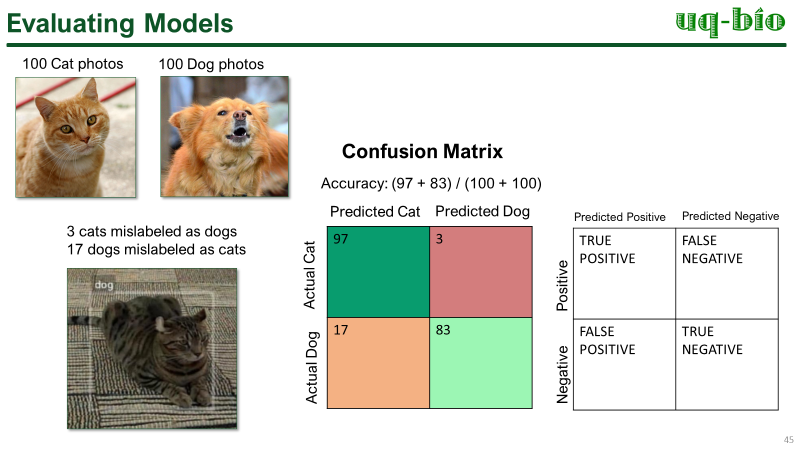

### Confusion Matrix

Balanced accuracy vs unbalanced metrics
 
While a balanced accuracy in general is a good call, specific applications may call for different so-called unbalanced metrics. Consider the following scenario:
 
 
> You are designing an antigen test for a disease like Sars-Cov-2, would you rather have a balanced false positive and false negative rate? or would you rather emphasize minimizing as many False negatives as possible? The consequences for a false positive are a person quarantines for some period of time or takes subsequent tests; Whereas the consequences for a false negative is a person with an infectious disease not quarantining.
 
The reverse situation may also happen:
 
> Imagine a diagnostic test where the treatment from a positive diagnostic is intensive or dangerous. One would want to minimize the false positive rate as much as possible to avoid unnecessary treatments to healthy people.
 

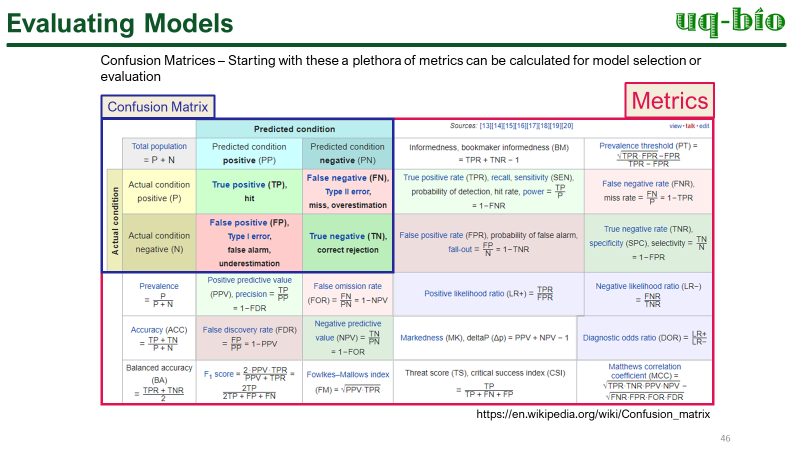

In [ ]:
model_prediction = model.predict(x_val)  # apply our cnn_model
Y_pred = tf.argmax(model_prediction,axis=1).numpy() # get the prediction back out
Y_true = label_val

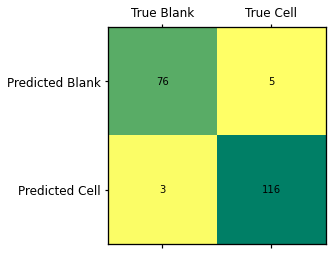

In [ ]:
conf = confusion_matrix(Y_true, Y_pred)  # get a confusion matrix

# plot our confusion matrix
fig,ax = plt.subplots(1,1)
ax.grid(False)
ax.matshow(conf,cmap='summer_r')

for i in range(conf.shape[0]):
  for j in range(conf.shape[1]):
    ax.text(i,j, str(conf[i,j]), va='center', ha='center',color='black')

ax.set_xticklabels(['','True Blank', 'True Cell',''])
ax.set_yticklabels(['','Predicted Blank','Predicted Cell',''])
print('')

### Receiver Operator Characteristic (ROC curve)

Receiver Operator Characteristic Curves are constructed by plotting True Positive rate (TP / Total P) vs False Positive Rate (FP / Total P).

An ROC is constructed by setting a stricter and stricter threshold for what is considered a positive label, starting from > 0.5 to > 0.999. Consider the following table:

| Actual Label |  Prediction Probability | Positive threshold | ( > 0.5)| ( > 0.75) | ( > 0.90) | ( > 0.95) | 
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |----------- |
| 1      | .85  |      | 1 | 1 | 0 | 0 
| 0    |.5    |   | 0 | 0 | 0 | 0 
| 1   |.98    |   | 1 | 1 | 1 | 1 
| 1    |.7      | | 1 | 0 | 0 | 0 
| 1    |.6      | | 1 | 0 | 0 | 0 
| 0   |.3      || 0 | 0 | 0 | 0 
| 0   |.2      || 0 | 0 | 0 | 0 
| 0   |.01      || 0 | 0 | 0 | 0 

|  |  ( > 0.5)| ( > 0.75) | ( > 0.90) | ( > 0.95) | 
| ----------- | ----------- | ----------- | ----------- | ----------- |
| TPR | 1  | .5 | .25 | .25 | 
| FPR | 1 | .33  | .43 |  .43 |






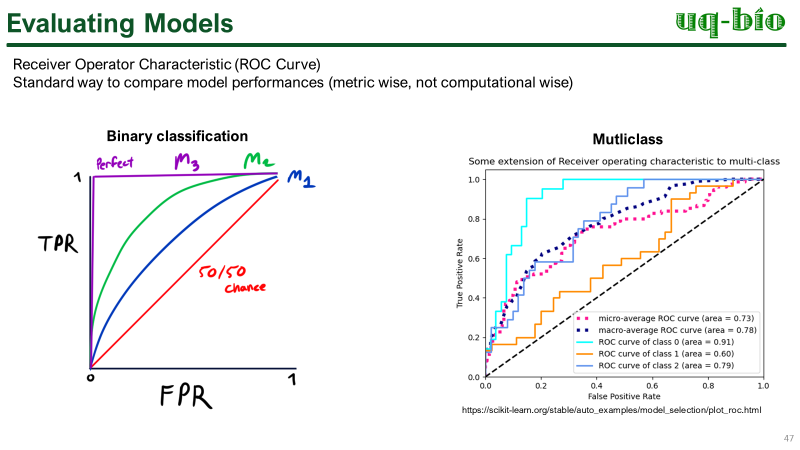

Text(0, 0.5, 'TPR')

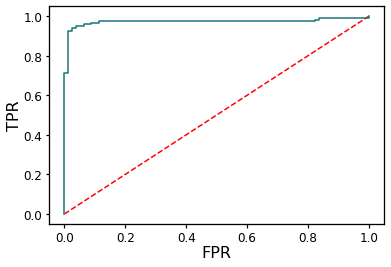

In [ ]:
from sklearn.metrics import roc_curve, auc

FPR, TPR, thresh = roc_curve(Y_true,model_prediction[:,1])
plt.plot([0,1],[0,1],'r--')
plt.plot(FPR,TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')

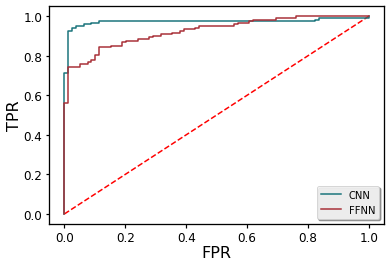

In [ ]:
## Comparing the CNN and FFNN we trained with an ROC plot

FPR, TPR, thresh = roc_curve(Y_true, model_prediction[:,1])
plt.plot([0,1],[0,1],'r--',label='_nolegend_')
plt.plot(FPR,TPR)
FPR, TPR, thresh = roc_curve(Y_true,ffnn_pred )
plt.plot(FPR,TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['CNN','FFNN'],loc='lower right')

## Applying our classifier(s) to a big microscope image to detect cells

In [ ]:
#@title Creating a large stitched microscope image from our original 128x128 images
## combining images back together
stitch_size = 3
start_ind = np.random.randint(1296)  #pick random middle image
stitched_image = np.zeros([128*stitch_size,128*stitch_size,3],dtype=np.uint16)
norm_stitched_image = np.zeros([128*stitch_size,128*stitch_size,3],dtype=float)

#pick 8 random images to ring around the center image
inds = np.zeros([3,3],dtype=int)
inds[int(stitch_size/2), int(stitch_size/2)] = np.random.randint(1296)
inds[int(stitch_size/2)-1, int(stitch_size/2)] = np.random.randint(1296)
inds[int(stitch_size/2)+1, int(stitch_size/2)] = np.random.randint(1296)
inds[int(stitch_size/2), int(stitch_size/2)+1] = np.random.randint(1296)
inds[int(stitch_size/2), int(stitch_size/2)-1] = np.random.randint(1296)
inds[int(stitch_size/2)-1, int(stitch_size/2)-1] = np.random.randint(1296)
inds[int(stitch_size/2)+1, int(stitch_size/2)-1] = np.random.randint(1296)
inds[int(stitch_size/2)+1, int(stitch_size/2)+1] = np.random.randint(1296)
inds[int(stitch_size/2)-1, int(stitch_size/2)+1] = np.random.randint(1296)

# stitch the numpy arrays together
for i in range(stitch_size):
  for j in range(stitch_size):
    stitched_image[128*i : 128*i + 128, 128*j : 128*j + 128, :] = X_128[inds[i,j]]
    norm_stitched_image[128*i : 128*i + 128, 128*j : 128*j + 128, :] = X_128[inds[i,j]]/ [np.max(X_128[:,:,:,0]), np.max(X_128[:,:,:,1]), np.max(X_128[:,:,:,2]),   ]

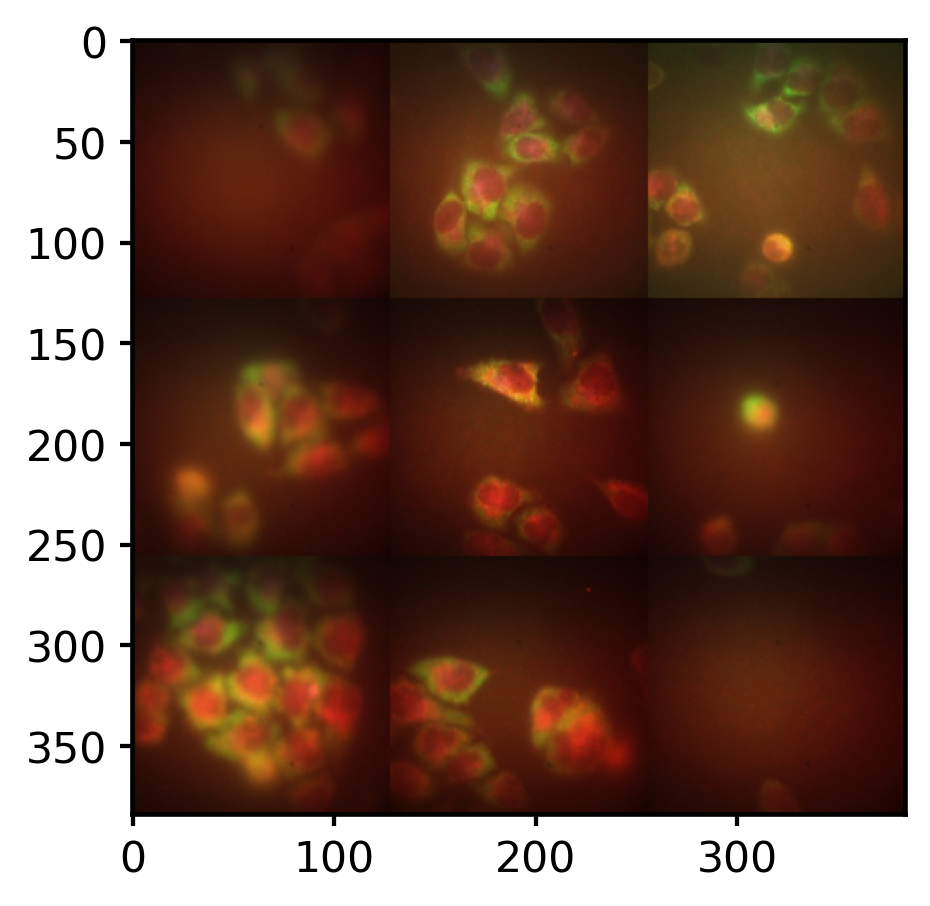

In [ ]:
## View our big new image
plt.rcParams['axes.grid']= False
plt.figure(dpi=256)
plt.imshow(stitched_image)

## Apply our CNN to our stitched image

In [ ]:
# lets apply our CNN we trained to blocks of 32x32 with offsets 0 and 16 to make a 
# "detection heatmap"

detected_cells = np.zeros([128*3,128*3],dtype=float)
for i in range(int(128*3/32)):
  for j in range(int(128*3/32)):
    detected_cells[32*i : 32*i + 32, 32*j : 32*j + 32] = model.predict(np.array([stitched_image[32*i : 32*i + 32, 32*j : 32*j + 32, :]]))[0,1]


detected_cells_offset = np.zeros([128*3,128*3],dtype=float)
for i in range(int(128*3/32)-1):
  for j in range(int(128*3/32)-1):
    if i not in [3,7,11] and j not in [3,7,11]: # dont classify the seams 
      detected_cells_offset[32*i+16 : 32*i+16 + 32, 32*j+16 : 32*j+16 + 32] = model.predict(np.array([stitched_image[32*i+16 : 32*i+16 + 32, 32*j+16 : 32*j+16 + 32,:]]))[0,1]

In [ ]:
#@title custom cmap for highlighting the cells
from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('jet')(range(ncolors))
color_array[:128,-1] = 0
color_array[128:128+32] = np.array([235, 131, 52,255])/255 
color_array[128+32:128+32*2,] = np.array([227, 203, 20, 255]) /255 
color_array[128+32*2:128+32*3,] = np.array([192, 204, 57, 255])/255 
color_array[128+32*3:128+32*4,] = np.array([123, 250, 50,255])/255  

map_object = LinearSegmentedColormap.from_list(name='greens_alpha',colors=color_array)
plt.register_cmap(cmap=map_object)


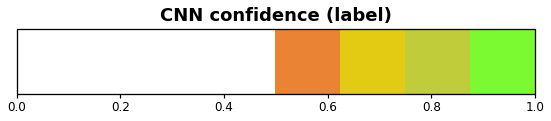

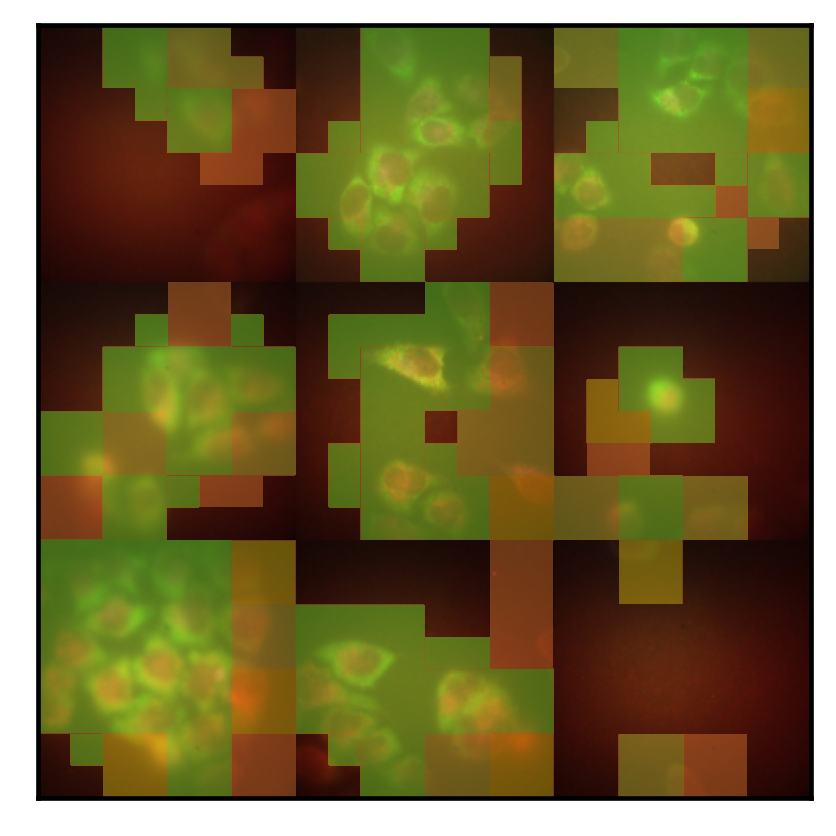

In [ ]:
## making our heatmap

###################
#setup the color bar
a = np.array([[0,1]]) 
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="greens_alpha") #using our new custom cmap
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.title('CNN confidence (label)')

##################
# Make the stitched image heatmap
fig = plt.figure(dpi=256)

ax=fig.add_subplot(111)

import matplotlib.ticker as plticker
myInterval=16.
loc = plticker.MultipleLocator(base=myInterval)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(True, ls='-', lw=.5)
ax.imshow(stitched_image,alpha=1) #stitched together image
ax.imshow(detected_cells_offset,alpha=1,cmap='greens_alpha') #output of CNN on 32x32 w/ offset 16
ax.imshow(detected_cells, alpha=1,cmap='greens_alpha') #output of CNN on 32x32 w/ offset 0
ax.imshow(stitched_image,alpha=.6) #stitched together image
#comment this out if you want to see the grid
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


### Visualizing Convolutional layers extracted Features

64


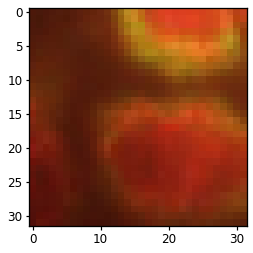

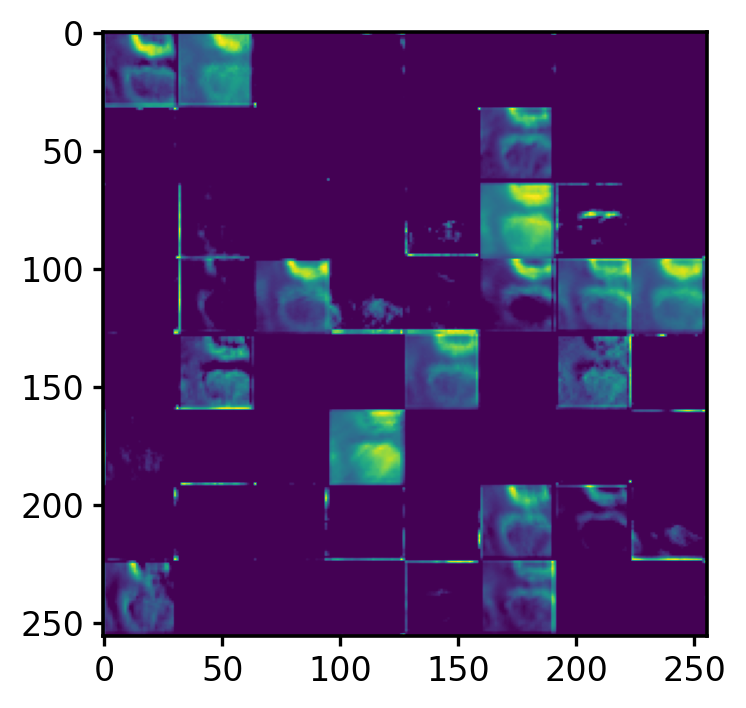

In [ ]:
ind = 105 #@param {type:"slider", min:0, max:999, step:1} 
cnn_layers = 1 #@param {type:"slider",min:1,max:6}
normalize = True #@param {type:"boolean"}
plt.imshow(X[ind])

def run_layers(image,n_layers):
  x = np.array([image]).astype(float)
  for i in range(n_layers):
    x = model.layers[i](x)
  return x.numpy()

features = run_layers(X[ind],cnn_layers)
n_features = features.shape[-1]
n_ax = max([n for n in range(1, int(1*n_features/4)) if n_features % n == 0])
print(n_features)
#fig,ax=plt.subplots(n_ax,int(n_features/n_ax),dpi=200, tight_layout=True)
k=0

new_feature_image = np.zeros([features.shape[1]*n_ax, features.shape[2]*int(n_features/n_ax)])
for i in range(n_ax):
  for j in range(int(n_features/n_ax)):
    if normalize:
      tmp = features[0,:,:,k]/max(features[0,:,:,k].max(),1)
      new_feature_image[i*features.shape[1]:i*features.shape[1]+features.shape[1], j*features.shape[2]:j*features.shape[2]+features.shape[2]] = tmp
    else:
      new_feature_image[i*features.shape[1]:i*features.shape[1]+features.shape[1], j*features.shape[2]:j*features.shape[2]+features.shape[2]] = features[0,:,:,k]
    k+=1
    
plt.figure(dpi=200)
plt.imshow(new_feature_image)

### Dense Layer Visualization

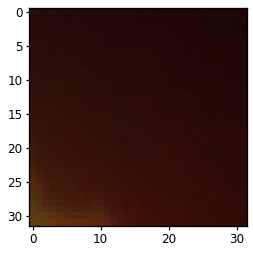

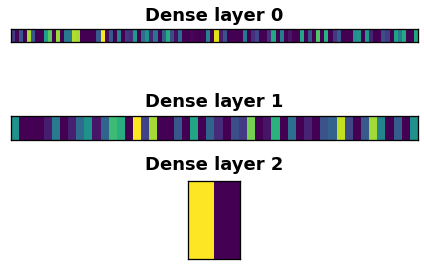

In [ ]:
ind = 806 #@param {type:"slider", min:0, max:999, step:1} 

plt.imshow(X[ind])

def get_cnn_flat(image,n_layers=7):
  x = np.array([image]).astype(float)
  for i in range(n_layers):
    x = model.layers[i](x)
  return x.numpy()

def get_ffnn_activations(cnn_output_flat):
  x = cnn_output_flat
  output_features = []
  for i in range(7,len(model.layers)):
    output_features.append(model.layers[i](x).numpy())
    x = model.layers[i](x)

  return output_features

cnn_out = get_cnn_flat(X[ind])
ffnn_features = get_ffnn_activations(cnn_out)

fig,ax = plt.subplots(3,1, tight_layout=True)

sizes = [len(ffnn_features[i][0]) for i in range(len(ffnn_features))]
sh = [len(model.layers) - 7, max(sizes)]
ffnn_image = -1*(np.ones(sh))
k = 0
for i in range(len(model.layers) - 7):
  if isinstance(model.layers[7+i], keras.layers.Dense):
    ax[k].matshow(np.atleast_2d(ffnn_features[i][0]),aspect=3)
    ax[k].get_xaxis().set_visible(False)
    ax[k].get_yaxis().set_visible(False)
    ax[k].set_title('Dense layer %i'%k)
    k+=1
    



## Machine learning and Ethics

In computational biology this usually does not become a consideration until you are creating diagnostic tools. Nevertheless, it is still good to run down some of the ethical considerations of training machine learning models of various types.


----------

Common ethical considerations:



#### **Reinforcement of Socioeconomic Trends**
 
Implementations of models for applications such as credit lines, recidivism rates, or hiring practices are exceptionally prone to bias; In a sociologically biased society, datasets are prone to contain that inherent bias. If that bias is present in the data, resulting models can recreate that bias with the added "benefit" of laundering responsibility through a perceived impartial third party actor.
 
Relying on biased models can serve to chill any social mobility and societal progress and mask discriminatory practices from public scrutiny for longer than if the bias was human derived. This effect is especially prevalent if a model is not constantly retrained. A model is learning on historical snapshot data and is out of date, yet is still relied on for important, life-altering decisions concerning things such as housing, incarceration, or employment.
 
 
Additionally, access to these models  may be limited to those nations, persons, or entities wealthy enough to utilize and compute the models. For example consider a machine learning suite focused on providing accurate Market Trading predictions that is also paywalled. Those already 1. wealthy enough to market trade and 2. pay for the subscription are now privy and able to accrue more wealth than those starting from a lower capital amount, increasing the "activation energy" of economic mobility.
 
----
 
Case study: [COMPRAS](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing),  and algorithm designed to predict risk of reoffending of a given incarcerated person, was systemically biased towards people of color and inaccurate in its predictions and was heavily relied upon by judges in sentencing.
 
|  COMPRAS Prediction and True outcome    | White |  African American|
| ----------- | ----------- | ---- |
| Labeled High Risk, but did not re-offend      | 23.5%       | 44.9% | 
| Labeled Low Risk, but did re-offend   | 47.7%        | 28.0%   | 

#### **Entrenchment of Current Medical Paradigms**
 
Similar to the above points but from a medical perspective, supervised models are only as good as their generalizability and the data provided to them to learn. In fields like Medicine (and also Computational biology) care must be taken to remember at all times that these fields are constantly discovering new evidence, refining previous understanding, and revising old paradigms of treatment and knowledge. Models trained on snapshot data or on feature sets are ill suited to new or emerging diseases and poorly understood / historically under-served conditions. Adding in diagnostic machine learning models may add another obstacle when attempting to get adequate care. 
 
For a thought experiment: Consider the newly recognized condition called Alpha-Galactose Allergy, (Tick-borne Mammalian meat allergy). Preliminary evidence of this condition emerged in the early 2000's and was unrecognized by doctors until circa 2008-2010. The presentation of this condition was varied, non-specific, and rare; Features that prevented discovery until a specific cancer drug containing Alpha-Galactose caused several severe anaphylaxis cases but only in geographic regions containing high rates of tick borne illness. Any sort of diagnostic contemporary machine learning based tool would have not caught this disease as it was not described and rare. Those with the condition may have been repeatedly rejected (more than they were) due to over reliance on such a tool and discovery may have been masked for a longer period of time.
 
 
 
 



#### **Lacking or Missing Explanatory Outcomes**
 
Some machine learning models may only return a classification or confidence score + label. The lack of explanatory power can arise to black box situations when an explanation is needed. Consider popular CNNs trained to diagnose melanomas when compared to a dermatologist's recommendation. The dermatologist can point to many features and explain their decision of whether a blemish is benign or malignant: Features like, roundness, color, size, hair, family history, occupational history. The CNN, unless it has been explicitly designed to return the information, may require a lot of scrutiny to reconstruct its "opinion" or decision making process. There is a plethora of ethical concerns one can list that may arise from a ML model without explainatory features:
 
  1. Obligation to provide explanatory care to patients
  2. Lack of transparency when explaining misdiagnosis for liability reasons
  3. Epistemic undermining of already existing experts and disciplines
 



 
#### **Incomprehensive and Imbalanced Datasets**
 
Datasets can be oversaturated or imbalanced with a particular type of statistic, leading to a lack of generalization and hyperspecialization by a given model. This is especially possible when big data is collected and is infeasible for entry by entry examination by a human. Computing summary statistics and studious understanding of your dataset before attempting machine learning is recommended. 
 
Case Study: An imbalanced or biased dataset was used to train Twitter's thumbnail algorithm, which would focus on white people for attention over people of color. This has since been updated to select thumbnails based on arbitrary center cropping.


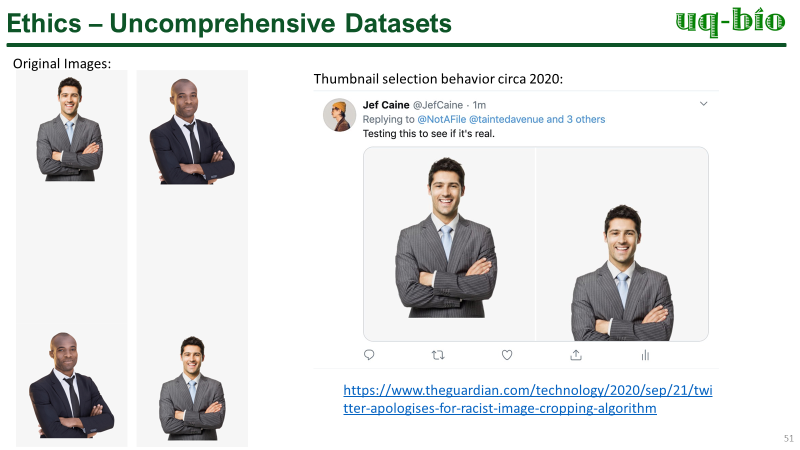

#### **Legal Gray Areas**
 
* Liability
 
  * Outcomes of machine learning models are a legal gray area in many countries. If a fully autonomous self driving car strikes a person or property, who is liable for damages? Is the car manufacturer negligent for all edge cases that an AI may encounter?
 
* Consent
  * Data privacy is a developing area of law, the [US currently as of 2022 has no federal guideline for personal data protections](https://www.nytimes.com/wirecutter/blog/state-of-privacy-laws-in-us/), instead america has specific laws like COPPA or HIPPA for specific data (children's data / healthcare data respectively for those two). This means actors in America are free to mostly build datasets without the consent of the people who generate that data. This is an ethical concern to right to privacy advocates since often, even with anonymizing and barcoding, [entries can easily be tied to individuals.](https://techcrunch.com/2019/07/24/researchers-spotlight-the-lie-of-anonymous-data/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAKfGXHUjL3AH6xAdh-MDG-eMsxVnFxbLsVNHXfqNx75V9VBzsfvnt7_QrgZqn1gatfLq2OXKPkPYlZfpTQD21UjDxx7FsPkq1vHLNSJSq6JhOb5hnQhBkIFe_mKtQY_b2F32T4Ke6ydgA0KBAd-0w3m0NvnujlBr0e1gEgm1-JJ9)
 
* Copyright
  * When training models on copyrighted works, such as artwork or written works, are the works produced by the ML model subject to copyright or derivatives? What if an ML model overfits one particular artist's work or style, such that it is reproducing works with 99.9% accuracy? 


-------


Further Reading
<details>
  <summary>Click to Expand</summary>


----------------------------

Academic Papers:

* [Ethical principles in machine learning and artificial intelligence: cases from the field and possible ways forward](https://www.nature.com/articles/s41599-020-0501-9) - Overview and introduction to ML ethics with 2 case studies - Piano S. (Nature 2020)

* [The global landscape of AI ethics guidelines](https://www.nature.com/articles/s42256-019-0088-2) - Jobin et al. (Nature Machine Intelligence 2019) - Scoping review about the state of AI ethics.


* [The Ethics of AI Ethics: An Evaluation of Guidelines](https://link.springer.com/article/10.1007/s11023-020-09517-8) - Hagendorff (Minds and Machines 2020) - Article and systemic review about areas lacking in recent AI industry guidelines.

Academic Papers w/ focus on Medicinal practice:

* [Implementing Machine Learning in Health Care — Addressing Ethical Challenges](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5962261/) - Char et al. (The New England Journal of Medicine 2019)

* [On the ethics of algorithmic decision-making in healthcare](https://jme.bmj.com/content/46/3/205) - Grote et al (Journal of Medical Ethics 2019) 

Industry White Papers:

* [How to Prevent Discriminatory Outcomes in Machine Learning](https://www3.weforum.org/docs/WEF_40065_White_Paper_How_to_Prevent_Discriminatory_Outcomes_in_Machine_Learning.pdf) - World Economic Forum white paper (2019)

* [The Malicious Use of Artificial Intelligence: Forcasting, Prevention, and Mitigation](https://arxiv.org/ftp/arxiv/papers/1802/1802.07228.pdf) - Future of Humanity Institute (2018)

</details>

## Questions and Discussion
 
To receive credit, answer the following free response questions and at least 2 of the harder questions.


--------------------------
Easy Questions
 
* Which type of machine learning returns out a continuous value output to match or predict something like a price?
 
* What is the difference between one-hot encoding and a label?
 
* What would you call a dataset where the features are not related to each other, i.e. you could shuffle the columns and have the same dataset? 
 
* What is the difference between validation and cross validation?
 
* What is happening when you have very good accuracy on your training set but terrible accuracy on your validation set?
 
* What is happening when you have low model variance but high bias?
 
-------------------------------

Harder Questions

* What final layer assumes the output labels are distinct independent possibilities and will convert an activation to an independent probability across classes (output may not sum to 1)?
 
* What final layer assumes the output labels are concomitant possibilities and will convert an activation to joint probability across all classes (output sums to 1)?
 
* How would you train on a dataset that has overlapping labels? for example imagine a dataset of shapes where your labels are [ circle, oval, rectangle, square], some entries may have the one-hot label [1,1,0,0] for a perfect circle, while an oval will only have [0,1,0,0].
 
 
* Theres a trivial filter that can help out our FFNN, test different filters and then devise feature extractions for those filtered images that get a higher accuracy than 80% with a simple FFNN .

 -------------------
Discussion Questions for the class:
 
* What do you do if you have no negative labels?
 
* What are some areas of ethical concern within your discipline using AI?
 
* What are some of your favorite ML models out there?


---------------------------
 
 Bonus questions (derivations):

 
* Derive the equation we use for solving directly for the linear regression weights that minimize the sum of squared errors. 

\begin{equation}
W = (\bar{X}^T\cdot \bar{X})^{-1}\bar{X}^T \cdot \bar{Y} = pseudoinverse(\bar{X})*\bar{Y}
\end{equation}

starting from the formulation:
$
\begin{align}
\bar{Y} = W\cdot\bar{X}
\end{align}
$
\begin{align}
\mathbf{\bar{Y}} = \begin{bmatrix}
y_1&\\
y_2&\\
\vdots&\\
y_n&\\
\end{bmatrix}	
\mathbf{W} = \begin{bmatrix}
w_1&\\
w_2&\\
\vdots&\\
w_n&\\
\end{bmatrix}	
\mathbf{\bar{X}} = \begin{bmatrix}
x_{1,1}& x_{1,2} &\cdots& x_{1,i}\\
x_{2,1}& \ddots & &\vdots&\\ 
\vdots& & \ddots&\\
x_{n,1}& \cdots& & x_{n,i}\\
\end{bmatrix}	
\end{align}


for $n$ observations of $i$ features.

<details>
  <summary>HINT</summary>
 Write out the formula for the error between prediction Y_hat and Real value Y_bar and minimize the gradient of this formula.
<details>

In [ ]:
#@title unused cells

1/0
from PIL import Image

if not os.path.exists('/content/subimages'):
  os.mkdir('/content/subimages')

size=(32,32)
n=1000
tarfilename ='random_subsamples_128.tar.gz'
## get all images into np arrays
imgs = []
fullFilePaths = glob.glob('images_128/*.jpg')
statistics=dict()
for fullFilePath in fullFilePaths:
    filePathSplitIntoList=fullFilePath.split('_')
    ImageFileStringAndExtenstion=filePathSplitIntoList[2].split('.')
    imageIdAsInteger=int(ImageFileStringAndExtenstion[0])
    image = Image.open(fullFilePath)
    imageAsNumpyArray = np.array(image).astype('int32')
    imgs.append(imageAsNumpyArray)
    #statisticsCalculator = ImageSummaryStatisticsBrian()
    #statistics[imageIdAsInteger] = statisticsCalculator.calculate(imageAsNumpyArray)

X_128 = np.array(imgs)
'''
inds = np.zeros([2,n])
for i in range(n):
  nimage = np.random.randint(0,len(X)) 
  x,y = np.random.randint(0,128-size[0]), np.random.randint(0,128-size[1])
  subimage = X[nimage, x:x+size[1],y:y+size[1],:]
  im = Image.fromarray(subimage.astype(np.uint8), mode="RGB")
  im.save("/content/subimages/%i.png"%i, "PNG")
  inds[:,i] = [x,y]
os.system('!tar -czvf "/content/%s "/content/subimages"'%tarfilename  )
np.save('subimage_inds.npy',inds)
'''



##################

    def getFFTHighFrequency(self,image):
        maxdim = image.shape[0]
        margin=round(maxdim/4)
        fImage = np.fft.fft2(image)
        fImage = np.fft.fftshift(fImage)
        fImage = np.abs(fImage)
        mask=np.zeros(fImage.shape)
        mask[0:margin, :, :] = 1
        mask[(maxdim - margin):maxdim, :, :] = 1
        mask[:, 0:margin, :] = 1
        mask[:, (maxdim - margin):maxdim, :] = 1
        magnitude = [None, None, None]
        for i in range(len(magnitude)):
            m = np.multiply(fImage[:, :, i], mask[:, :, i])
            magnitude[i] = np.sum(np.sum(m))
        return magnitude

    def getFFTLowFrequency(self,image):
        maxdim = image.shape[0]
        midpoint=round(maxdim/2)
        fImage = np.fft.fft2(image)
        fImage = np.fft.fftshift(fImage)
        fImage = np.abs(fImage)
        mask = np.zeros(fImage.shape)
        mask[(midpoint - 5):(midpoint +1 + 5), (midpoint -1 - 5):(midpoint +1 + 5),:] = 1
        magnitude=[None,None,None]
        for i in range(len(magnitude)):
            m = np.multiply(fImage[:,:,i], mask[:,:,i])
            magnitude[i] = np.sum(np.sum(m))
        return magnitude

    def getFFTMidFrequency(self,image):
        maxdim=image.shape[0]
        midpoint=round(maxdim/2)
        margin=round(maxdim/4)
        fImage = np.fft.fft2(image)
        fImage = np.fft.fftshift(fImage)
        fImage = np.abs(fImage)
        mask = np.ones(fImage.shape)
        mask[0:margin, :, :] = 0
        mask[(maxdim-margin):maxdim, :, :] = 0
        mask[:,0:margin, :] = 0
        mask[:,(maxdim - margin):maxdim, :] = 0
        mask[(midpoint - 5):(midpoint +1 + 5), (midpoint -1 - 5):(midpoint +1 + 5),:] = 0
        magnitude = [None, None, None]
        for i in range(len(magnitude)):
            m = np.multiply(fImage[:, :, i], mask[:, :, i])
            magnitude[i] = np.sum(np.sum(m))
        return magnitude

    def getHistogram(self,image,threshold):
        value=[None,None,None]
        for index in range(3):
            page = image[:, :, index]
            page=page.flatten()
            value[index]=np.percentile(page,threshold)
        return value


imgs = []
fullFilePaths = glob.glob('images_128/*.jpg')
statistics=dict()
for fullFilePath in fullFilePaths:
    filePathSplitIntoList=fullFilePath.split('_')
    ImageFileStringAndExtenstion=filePathSplitIntoList[2].split('.')
    imageIdAsInteger=int(ImageFileStringAndExtenstion[0])
    image = Image.open(fullFilePath)
    imageAsNumpyArray = np.array(image).astype('int32')
    imgs.append(imageAsNumpyArray)
    statisticsCalculator = ImageSummaryStatisticsBrian()
    statistics[imageIdAsInteger] = statisticsCalculator.calculate(imageAsNumpyArray)
X = np.array(imgs)


#@ Define the features and associated target
def StatsAsVector(stats):
  features=np.array([])   
  for k in stats.keys():
    features = np.append(features,np.array(stats[k]))
  return features
  
features = np.array([StatsAsVector(statistics[i]) for i in range(len(statistics))])
print(features.shape)

targets=[]
for x in np.arange(-1800.,1800.,100):
   for y in np.arange(-1800.,1800.,100):   
       targets.append((x**2.+y**2.)**(0.5))
targets = np.array(targets)
# print(targets.shape)

features = np.hstack((features, features**2,features**3))
Regression_Coeffs = (np.linalg.inv(features.T @ features) @ features.T @ targets)

rval = lambda x,y:  (len(x)*(np.sum(np.multiply(x,y))) - np.sum(x)*np.sum(y)) / np.sqrt((len(x)*np.sum(np.multiply(x,x)) - np.sum(x)**2)*(len(x)*np.sum(np.multiply(y,y)) - np.sum(y)**2))

fig, ax=plt.subplots(1,1)
ax.scatter(features @ Regression_Coeffs, targets)
ax.plot([0,2500],[0,2500],'r')
print(np.corrcoef(features @ Regression_Coeffs, targets))

ax.set_title( 'Linear Regression, R^2=%f'%rval(features @ Regression_Coeffs, targets)**2, fontsize=10,)





#################



v_edge_kernel = np.array([[1,0,-1],
                          [2,0,-2],
                          [1,0,-1]],dtype=int)

h_edge_kernel = v_edge_kernel.T


def convolution2d(image, kernel, bias=0, padding='zeros'):
  m,n = kernel.shape
  image_shape = image.shape
  padx = m-1
  pady = n-1
  padded_image = np.zeros([image.shape[0]+2*padx, image.shape[1] + pady*2],dtype=image.dtype)
  padded_image[padx:-padx,pady:-pady] = image
  convolved_image = np.zeros([image.shape[0]+padx*2, image.shape[1]+pady*2])

  for i in range(image.shape[0]+padx*2-4):
    for j in range(image.shape[1]+pady*2-4):
      #convolved_image[i][j] = np.sum(padded_image[i:i+m,j:j+n]*kernel)+bias
      convolved_image[i][j] = np.sum(padded_image[i:i+m, j:j+n]*kernel) + bias
  return convolved_image[padx:-padx-2,pady:-pady-2]
  

positive_edges = np.sqrt(convolution2d(positive_example[:,:,1], v_edge_kernel,0)**2 + convolution2d(positive_example[:,:,1],h_edge_kernel,0)**2 )
negative_edges = np.sqrt(convolution2d(negative_example[:,:,1],v_edge_kernel,0)**2 + convolution2d(negative_example[:,:,1],h_edge_kernel,0)**2)

fig,ax = plt.subplots(1,2,dpi=120)
ax[0].imshow(positive_edges.astype(float))

ax[1].imshow(negative_edges.astype(float))

def edge_detect(image, kernel='sobel', axis=-1):
  if kernel == 'sobel':
    h_edge = np.array([[1,2,1],[0,0,0],[-1,-2,1]])
    v_edge = h_edge.T
  
  imageshape = image.shape

  new_image = np.zeros((imageshape[0]-2, imageshape[1]-2,imageshape[-1]), dtype=image.dtype)

  if len(imageshape) >2:
    for i in range(imageshape[-1]):
      new_image[:,:,i] = np.sqrt(convolution2d(image[:,:,i],h_edge,0)**2 + convolution2d(image[:,:,i],v_edge,0)**2)
    return new_image
  else:
  
    return np.sqrt(convolution2d(image,h_edge,0)**2 + convolution2d(image,v_edge,0)**2)


plt.imshow(edge_detect(positive_example[:,:,1]))

X_edges = np.zeros([X.shape[0],X.shape[1]-2, X.shape[2]-2,X.shape[-1]])
for i in range(len(X)):
  X_edges[i] =  edge_detect(X[i])



############ FFNN applied to images ########################


detected_cells = np.zeros([128*3,128*3],dtype=float)
for i in range(int(128*3/32)):
  for j in range(int(128*3/32)):
    img = np.array([norm_stitched_image[32*i : 32*i + 32, 32*j : 32*j + 32, :]])
    X_feat = get_features_from_image(np.array([norm_stitched_image[32*i : 32*i + 32, 32*j : 32*j + 32, :]]))
    detected_cells[32*i : 32*i + 32, 32*j : 32*j + 32] = ffnn_model.predict(np.array(X_feat)[np.newaxis,[0,1,2,-3,-2,-1]] )[0,1]


detected_cells_offset = np.zeros([128*3,128*3],dtype=float)
for i in range(int(128*3/32)-1):
  for j in range(int(128*3/32)-1):
    if i not in [3,7,11] and j not in [3,7,11]: # dont classify the seams 
      X_feat = get_features_from_image(np.array([norm_stitched_image[32*i : 32*i + 32, 32*j : 32*j + 32, :]]))
      detected_cells_offset[32*i+16 : 32*i+16 + 32, 32*j+16 : 32*j+16 + 32] = ffnn_model.predict(np.array(X_feat)[np.newaxis,[0,1,2,-3,-2,-1]] )[0,1]

a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="greens_alpha")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.title('FFNN confidence (label)')

##################
fig = plt.figure(dpi=256)

ax=fig.add_subplot(111)

import matplotlib.ticker as plticker
myInterval=16.
loc = plticker.MultipleLocator(base=myInterval)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(True, ls='-', lw=.5)

ax.imshow(stitched_image,alpha=1) #stitched together image
ax.imshow(detected_cells_offset,alpha=1,cmap='greens_alpha') #output of FFNN on 32x32 w/ offset 16
ax.imshow(detected_cells, alpha=1,cmap='greens_alpha') #output of FFNN on 32x32 w/ offset 0

ax.imshow(stitched_image,alpha=.6) #stitched together image
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
